Here are a few thoughts for research questions:

1.) How much of a performance benefit does examining PI by POSGRU provide?
2.) How much of a performance benefit does adding meters gained into the analysis add?
3.) What does the explained variance and decision tree analysis tell us about POSGRU vs team-level key PI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sys
from scipy.stats import ttest_ind, zscore
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import copy
import json
import string

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams['axes.facecolor'] = 'white'

Michael Schlitzer

Primary References: 

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235


**Project Description:**

The goal of this project is to see if I can predict the outcome (home win / away win) of Australian Football League games by looking at the difference between the two teams' season-long performance in a number of standard AFL Performance Indicators (PI). Fahey-Gilmour, et.al. use a variety of categorical data points with regards to the individual matches (distance traveled, game location, etc.) and aggregate measures of team ladder position. They do not consider individual "contests" the same way that I am in this research.
Therefore, the goal of this effort is to use that comparative PI data in both optimized single perceptron machine learning algorithms and optimized multi-perceptron Neural Networks to see if I can outperform the benchmarks of 73.3% accuracy on the test sample set by Fahey-Gilmour, et.al.


**Learning Objective:** 

The primary objective of this project is to apply the techniques of choosing algorithms and parameters to a real-world dataset, one that has not been “worked out” in advance. This includes the optimization of the complex TensorFlow hyperparameters, including regularization and neural network parameters. By working on this data set, which holds personal interest for me, I am able to better understand the meaning and importance of each variable and parameter in the code.

**Preparatory Files:**

The data has required considerable reshaping and merging across multiple web sites and web pages.  The biggest challenge
was to reconfigure the data from one Performance Indicator all rounds in columns to all Performance Indicators as columns
and rounds as the index for each team for each season.  It was a challenge - one that was too daunting for me just a few months ago, but I was able to create nested dictionaries and export the dictionaries as a JSON file.  I obviously know the
structure of the JSON file, so reversing it to create a functional dataframe just takes a few lines of code.

Without doing any machine learning at all, getting to this point has been a point of pride for me.

In [2]:
teams = ['Adelaide', 'Brisbane', 'Carlton', 'Collingwood', 'Essendon', 'Fremantle', 'Geelong', 'Gold Coast', 
         'GWS', 'Hawthorn', 'Melbourne', 'North Melbourne', 'Port Adelaide', 'Richmond',
        'St. Kilda', 'Sydney', 'West Coast', 'Western Bulldogs']

years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [3]:
webpath = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/AFL_Season_Team_PI_Data_amg.json'
# test_path = 'C:/Users/Michael/Documents/UMBC/DataScience 606/AFL_Season_Team_PI_Data.json'
# test_path2 = 'C:/Users/Michael/Documents/UMBC/DataScience 606/AFL_Season_Team_PI_Data_amg.json'
AFL_Season_Team_PI_Data = pd.read_json(webpath)

In [4]:
new_season_team_PI = []
for y, year in zip(years, range(len(years))):
    new_team_round_PI = []
    for t, team in zip(teams, range(len(teams))):
        new_round_PI = []
        
        for rnd in range(len(AFL_Season_Team_PI_Data[team][year])):
        
            new_rtc_df = pd.DataFrame.from_dict(AFL_Season_Team_PI_Data[team][year][rnd])
        
            new_round_PI.append(new_rtc_df)
        new_team_round_PI.append(new_round_PI)
    new_season_team_PI.append(new_team_round_PI)

In [5]:
master_seasonPI_df = pd.DataFrame()

for s in range(9):
    for t in range(18):
        master_seasonPI_df = master_seasonPI_df.append(new_season_team_PI[s][t])


In [6]:
master_seasonPI_df.reset_index(inplace = True)
master_seasonPI_df.rename(columns={'index': 'Round'}, inplace = True)
master_seasonPI_df['Round'] = master_seasonPI_df['Round'].str.replace('R','round')
master_seasonPI_df.fillna(value = 0, inplace = True)

In [7]:
with_ruck = master_seasonPI_df[master_seasonPI_df['R-HO'] != 0]

with_ruck[['D-HO', 'F-HO', 'M-HO', 'R-HO']]

with_ruck = with_ruck[with_ruck.loc[:] !=0].dropna(thresh = 4)

no_ruck = master_seasonPI_df[master_seasonPI_df['R-HO'] == 0]

no_ruck[['D-HO', 'F-HO', 'M-HO', 'R-HO']]

no_ruck = no_ruck[no_ruck.loc[:] !=0].dropna(thresh = 4)

baseline_with_ruck = with_ruck[['Season', 'D-HO', 'F-HO', 'M-HO', 'R-HO']].groupby('Season').mean()
baseline_without_ruck = no_ruck[['Season', 'D-HO', 'F-HO', 'M-HO', 'R-HO']].groupby('Season').mean()

# baseline_with_ruck

In [8]:
test_df = copy.deepcopy(master_seasonPI_df)

new_ruck_PI = pd.DataFrame(columns = ['R-HO', 'F-HO', 'D-HO', 'R-Age', 'R-Height', 'R-Weight'])

# This gets me the indices where there are no ruck stats
select_indices = list(np.where(test_df["R-HO"] == 0)[0])

for index in select_indices:
    yiq = test_df.iloc[index]['Season']
    
    if test_df.iloc[index][3:-3].sum() != 0:
    
        if test_df.iloc[index]['D-HO'] > 0 and test_df.iloc[index]['F-HO'] > 0:
            
            if test_df.iloc[index]['D-HO'] > baseline_with_ruck.loc[yiq]['D-HO'] and test_df.iloc[index]['F-HO'] > baseline_with_ruck.loc[yiq]['F-HO']:
    
                new_rho = (test_df.iloc[index]['D-HO'] - baseline_with_ruck.loc[yiq]['D-HO']) + (test_df.iloc[index]['F-HO'] - baseline_with_ruck.loc[yiq]['F-HO'])
                new_fho = baseline_with_ruck.loc[yiq]['F-HO']
                new_dho = baseline_with_ruck.loc[yiq]['D-HO']
                new_rage = (test_df.iloc[index]['D-Age'] + test_df.iloc[index]['F-Age']) / 2
                new_rh = (test_df.iloc[index]['D-Height'] + test_df.iloc[index]['F-Height']) / 2
                new_rw = (test_df.iloc[index]['D-Weight'] + test_df.iloc[index]['F-Weight']) / 2
            
            else:
                
                new_rho = 2.0
                new_fho = test_df.iloc[index]['F-HO'] - 1.0
                new_dho = test_df.iloc[index]['D-HO'] - 1.0
                new_rage = (test_df.iloc[index]['D-Age'] + test_df.iloc[index]['F-Age']) / 2
                new_rh = (test_df.iloc[index]['D-Height'] + test_df.iloc[index]['F-Height']) / 2
                new_rw = (test_df.iloc[index]['D-Weight'] + test_df.iloc[index]['F-Weight']) / 2

        elif test_df.iloc[index]['D-HO'] > 0:
            
            if test_df.iloc[index]['D-HO'] > baseline_with_ruck.loc[yiq]['D-HO']:

                new_rho = (test_df.iloc[index]['D-HO'] - baseline_with_ruck.loc[yiq]['D-HO'])
                new_fho = test_df.iloc[index]['F-HO']
                new_dho = baseline_with_ruck.loc[yiq]['D-HO']
                new_rage = test_df.iloc[index]['D-Age']
                new_rh = test_df.iloc[index]['D-Height']
                new_rw = test_df.iloc[index]['D-Weight']
                
            else:
                
                new_rho = 1.0
                new_fho = test_df.iloc[index]['F-HO']
                new_dho = test_df.iloc[index]['D-HO'] - 1.0
                new_rage = test_df.iloc[index]['D-Age']
                new_rh = test_df.iloc[index]['D-Height']
                new_rw = test_df.iloc[index]['D-Weight']

        elif test_df.iloc[index]['F-HO'] > 0:
            
            if test_df.iloc[index]['F-HO'] > baseline_with_ruck.loc[yiq]['F-HO']:

                new_rho = (test_df.iloc[index]['F-HO'] - baseline_with_ruck.loc[yiq]['F-HO'])
                new_fho = baseline_with_ruck.loc[yiq]['F-HO']
                new_dho = test_df.iloc[index]['D-HO']
                new_rage = test_df.iloc[index]['F-Age']
                new_rh = test_df.iloc[index]['F-Height']
                new_rw = test_df.iloc[index]['F-Weight']
                
            else:
                
                new_rho = 1.0
                new_fho = test_df.iloc[index]['F-HO'] - 1.0
                new_dho = test_df.iloc[index]['D-HO']
                new_rage = test_df.iloc[index]['F-Age']
                new_rh = test_df.iloc[index]['F-Height']
                new_rw = test_df.iloc[index]['F-Weight']

        new_list = [new_rho, new_fho, new_dho, new_rage, new_rh, new_rw]

        new_ruck_PI.loc[index] = new_list
    else:
        pass

nri = new_ruck_PI.index.tolist()
nrc = new_ruck_PI.columns

# new_ruck_PI.loc[59, 'F-HO'] # This is the pattern to change individual cells in a df
# df.loc[index, column_name] = the new value

for i in nri:
    for c in nrc:
        
        master_seasonPI_df.loc[i, c] = new_ruck_PI.loc[i, c]


In [9]:
index_names2 = master_seasonPI_df.loc[(master_seasonPI_df['Round'].isin(['round19', 'round20', 'round21', 'round22', 'round23'])) & (master_seasonPI_df['Season'] == '2020')].index
master_seasonPI_df = master_seasonPI_df.drop(index_names2)
master_seasonPI_df.replace({'Greater Western Sydney': 'GWS'}, inplace = True)
master_seasonPI_df['Season'] = pd.to_numeric(master_seasonPI_df['Season'])

master_seasonPI_df

,Round,Team,Season,D-DI,D-KI,D-MK,D-HB,D-GL,D-BH,D-HO,...,R-UP,R-CM,R-MI,R-1%,R-BO,R-AMG,R-GA,R-Height,R-Weight,R-Age
0,round1,Adelaide,2012,332.0,188.0,94.0,144.0,4.0,2.0,2.0,...,44.0,6.0,6.0,14.0,0.0,0.00,2.0,202.0,104.5,24.5
1,round2,Adelaide,2012,322.0,194.0,90.0,128.0,0.0,6.0,4.0,...,28.0,8.0,0.0,10.0,2.0,0.00,0.0,202.0,104.5,24.5
2,round3,Adelaide,2012,240.0,136.0,36.0,104.0,6.0,8.0,0.0,...,30.0,10.0,12.0,6.0,0.0,0.00,8.0,202.0,104.5,24.5
3,round4,Adelaide,2012,332.0,230.0,40.0,102.0,4.0,14.0,2.0,...,30.0,2.0,10.0,14.0,0.0,0.00,0.0,202.0,104.5,24.5
4,round5,Adelaide,2012,226.0,126.0,52.0,100.0,0.0,4.0,2.0,...,32.0,4.0,6.0,2.0,0.0,0.00,2.0,202.0,104.5,24.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,round13,Western Bulldogs,2020,111.0,66.0,38.0,46.0,1.0,0.0,0.0,...,14.0,1.0,1.0,2.0,0.0,392.61,0.0,201.5,91.0,21.5
3553,round14,Western Bulldogs,2020,86.0,54.0,31.0,32.0,4.0,2.0,0.0,...,24.0,1.0,0.0,7.0,0.0,392.61,0.0,201.5,91.0,21.5
3554,round16,Western Bulldogs,2020,73.0,39.0,31.0,35.0,1.0,3.0,0.0,...,17.0,4.0,0.0,8.0,0.0,392.61,0.0,201.5,91.0,21.5
3555,round17,Western Bulldogs,2020,150.0,90.0,44.0,62.0,5.0,4.0,0.0,...,22.0,0.0,1.0,6.0,0.0,392.61,0.0,201.5,91.0,21.5


# Cut the main df up into multiple experimental dfs to answer these exploratory questions (the data will have to be cut again after merger with the fixture schedule):

1.) Drop AMG from the 2012-2020 sample    2.) Create a 2015 - 2020 sample without AMG    3.) Drop 2012-2014 from the sample to focus on 2015 - 2020 with AMG.  This will let us test the impact of AMG as a predictor.

In [10]:
# The default df with no Average Meters Gained

drop_amg = [g for g in master_seasonPI_df if g.endswith(('-AMG'))]
df1 = master_seasonPI_df.drop(columns = drop_amg)
df1

,Round,Team,Season,D-DI,D-KI,D-MK,D-HB,D-GL,D-BH,D-HO,...,R-CP,R-UP,R-CM,R-MI,R-1%,R-BO,R-GA,R-Height,R-Weight,R-Age
0,round1,Adelaide,2012,332.0,188.0,94.0,144.0,4.0,2.0,2.0,...,30.0,44.0,6.0,6.0,14.0,0.0,2.0,202.0,104.5,24.5
1,round2,Adelaide,2012,322.0,194.0,90.0,128.0,0.0,6.0,4.0,...,22.0,28.0,8.0,0.0,10.0,2.0,0.0,202.0,104.5,24.5
2,round3,Adelaide,2012,240.0,136.0,36.0,104.0,6.0,8.0,0.0,...,46.0,30.0,10.0,12.0,6.0,0.0,8.0,202.0,104.5,24.5
3,round4,Adelaide,2012,332.0,230.0,40.0,102.0,4.0,14.0,2.0,...,30.0,30.0,2.0,10.0,14.0,0.0,0.0,202.0,104.5,24.5
4,round5,Adelaide,2012,226.0,126.0,52.0,100.0,0.0,4.0,2.0,...,24.0,32.0,4.0,6.0,2.0,0.0,2.0,202.0,104.5,24.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,round13,Western Bulldogs,2020,111.0,66.0,38.0,46.0,1.0,0.0,0.0,...,11.0,14.0,1.0,1.0,2.0,0.0,0.0,201.5,91.0,21.5
3553,round14,Western Bulldogs,2020,86.0,54.0,31.0,32.0,4.0,2.0,0.0,...,10.0,24.0,1.0,0.0,7.0,0.0,0.0,201.5,91.0,21.5
3554,round16,Western Bulldogs,2020,73.0,39.0,31.0,35.0,1.0,3.0,0.0,...,15.0,17.0,4.0,0.0,8.0,0.0,0.0,201.5,91.0,21.5
3555,round17,Western Bulldogs,2020,150.0,90.0,44.0,62.0,5.0,4.0,0.0,...,7.0,22.0,0.0,1.0,6.0,0.0,0.0,201.5,91.0,21.5


In [11]:
# df2 is 2015 - 2020 WITH AMG

df2 = master_seasonPI_df[master_seasonPI_df['Season'] > 2014]
df2

,Round,Team,Season,D-DI,D-KI,D-MK,D-HB,D-GL,D-BH,D-HO,...,R-UP,R-CM,R-MI,R-1%,R-BO,R-AMG,R-GA,R-Height,R-Weight,R-Age
1188,round1,Adelaide,2015,147.0,86.0,45.0,61.0,2.0,0.0,0.0,...,11.0,1.0,0.0,5.0,0.0,204.35,0.0,202.0,105.0,27.0
1189,round2,Adelaide,2015,173.0,111.0,61.0,62.0,2.0,3.0,0.0,...,14.0,2.0,0.0,2.0,0.0,204.35,0.0,202.0,105.0,27.0
1190,round3,Adelaide,2015,124.0,86.0,32.0,38.0,3.0,0.0,1.0,...,3.0,1.0,0.0,6.0,0.0,204.35,0.0,202.0,105.0,27.0
1191,round4,Adelaide,2015,128.0,85.0,41.0,43.0,0.0,2.0,0.0,...,9.0,1.0,0.0,3.0,1.0,204.35,0.0,202.0,105.0,27.0
1192,round5,Adelaide,2015,130.0,82.0,28.0,48.0,0.0,5.0,0.0,...,4.0,0.0,0.0,0.0,0.0,204.35,0.0,202.0,105.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,round13,Western Bulldogs,2020,111.0,66.0,38.0,46.0,1.0,0.0,0.0,...,14.0,1.0,1.0,2.0,0.0,392.61,0.0,201.5,91.0,21.5
3553,round14,Western Bulldogs,2020,86.0,54.0,31.0,32.0,4.0,2.0,0.0,...,24.0,1.0,0.0,7.0,0.0,392.61,0.0,201.5,91.0,21.5
3554,round16,Western Bulldogs,2020,73.0,39.0,31.0,35.0,1.0,3.0,0.0,...,17.0,4.0,0.0,8.0,0.0,392.61,0.0,201.5,91.0,21.5
3555,round17,Western Bulldogs,2020,150.0,90.0,44.0,62.0,5.0,4.0,0.0,...,22.0,0.0,1.0,6.0,0.0,392.61,0.0,201.5,91.0,21.5


In [12]:
# df3 is 2015 WITHOUT AMG

df3 = df1[df1['Season'] > 2014]
df3

,Round,Team,Season,D-DI,D-KI,D-MK,D-HB,D-GL,D-BH,D-HO,...,R-CP,R-UP,R-CM,R-MI,R-1%,R-BO,R-GA,R-Height,R-Weight,R-Age
1188,round1,Adelaide,2015,147.0,86.0,45.0,61.0,2.0,0.0,0.0,...,2.0,11.0,1.0,0.0,5.0,0.0,0.0,202.0,105.0,27.0
1189,round2,Adelaide,2015,173.0,111.0,61.0,62.0,2.0,3.0,0.0,...,10.0,14.0,2.0,0.0,2.0,0.0,0.0,202.0,105.0,27.0
1190,round3,Adelaide,2015,124.0,86.0,32.0,38.0,3.0,0.0,1.0,...,4.0,3.0,1.0,0.0,6.0,0.0,0.0,202.0,105.0,27.0
1191,round4,Adelaide,2015,128.0,85.0,41.0,43.0,0.0,2.0,0.0,...,9.0,9.0,1.0,0.0,3.0,1.0,0.0,202.0,105.0,27.0
1192,round5,Adelaide,2015,130.0,82.0,28.0,48.0,0.0,5.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,202.0,105.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,round13,Western Bulldogs,2020,111.0,66.0,38.0,46.0,1.0,0.0,0.0,...,11.0,14.0,1.0,1.0,2.0,0.0,0.0,201.5,91.0,21.5
3553,round14,Western Bulldogs,2020,86.0,54.0,31.0,32.0,4.0,2.0,0.0,...,10.0,24.0,1.0,0.0,7.0,0.0,0.0,201.5,91.0,21.5
3554,round16,Western Bulldogs,2020,73.0,39.0,31.0,35.0,1.0,3.0,0.0,...,15.0,17.0,4.0,0.0,8.0,0.0,0.0,201.5,91.0,21.5
3555,round17,Western Bulldogs,2020,150.0,90.0,44.0,62.0,5.0,4.0,0.0,...,7.0,22.0,0.0,1.0,6.0,0.0,0.0,201.5,91.0,21.5


# Taking an exploratory look at the data before I carve it up

In [13]:
# master_seasonPI_df_section = master_seasonPI_df.iloc[:-5]

# Here maybe I want to break it up into seasons with AMG and seasons without, or take out AMG.

season12 = master_seasonPI_df[master_seasonPI_df['Season'] == 2012]
season13 = master_seasonPI_df[master_seasonPI_df['Season'] == 2013]
season14 = master_seasonPI_df[master_seasonPI_df['Season'] == 2014]
season15 = master_seasonPI_df[master_seasonPI_df['Season'] == 2015]
season16 = master_seasonPI_df[master_seasonPI_df['Season'] == 2016]
season17 = master_seasonPI_df[master_seasonPI_df['Season'] == 2017]
season18 = master_seasonPI_df[master_seasonPI_df['Season'] == 2018]
season19 = master_seasonPI_df[master_seasonPI_df['Season'] == 2019]
season20 = master_seasonPI_df[master_seasonPI_df['Season'] == 2020]

# index_names = season20[season20['Round'].isin(['round19', 'round20', 'round21', 'round22', 'round23'])].index
# season20 = season20.drop(index_names)

In [14]:
# End of AMG sample section.  This is new.
season18

,Round,Team,Season,D-DI,D-KI,D-MK,D-HB,D-GL,D-BH,D-HO,...,R-UP,R-CM,R-MI,R-1%,R-BO,R-AMG,R-GA,R-Height,R-Weight,R-Age
2374,round1,Adelaide,2018,139.0,73.0,32.0,66.0,0.0,1.0,0.0,...,9.0,1.0,0.0,3.0,0.0,174.86,0.0,202.0,105.0,30.0
2375,round2,Adelaide,2018,188.0,111.0,51.0,77.0,0.0,0.0,0.0,...,13.0,1.0,0.0,2.0,0.0,174.86,1.0,202.0,105.0,30.0
2376,round3,Adelaide,2018,149.0,84.0,41.0,65.0,0.0,1.0,0.0,...,6.0,3.0,0.0,1.0,0.0,174.86,1.0,202.0,105.0,30.0
2377,round4,Adelaide,2018,141.0,79.0,34.0,62.0,0.0,0.0,0.0,...,4.0,0.0,0.0,2.0,0.0,174.86,0.0,202.0,105.0,30.0
2378,round5,Adelaide,2018,136.0,86.0,41.0,50.0,0.0,2.0,0.0,...,4.0,2.0,0.0,1.0,0.0,174.86,0.0,202.0,105.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,round19,Western Bulldogs,2018,112.0,80.0,19.0,32.0,2.0,2.0,28.0,...,7.0,0.0,0.0,5.0,0.0,132.75,0.0,200.0,100.0,28.0
2766,round20,Western Bulldogs,2018,123.0,61.0,26.0,62.0,1.0,2.0,19.0,...,12.0,2.0,1.0,4.0,0.0,132.75,1.0,200.0,100.0,28.0
2767,round21,Western Bulldogs,2018,108.0,47.0,33.0,61.0,1.0,0.0,20.0,...,6.0,0.0,0.0,2.0,0.0,132.75,1.0,200.0,100.0,28.0
2768,round22,Western Bulldogs,2018,101.0,64.0,37.0,37.0,2.0,0.0,24.0,...,8.0,0.0,2.0,1.0,1.0,132.75,1.0,200.0,100.0,28.0


<Figure size 576x504 with 0 Axes>

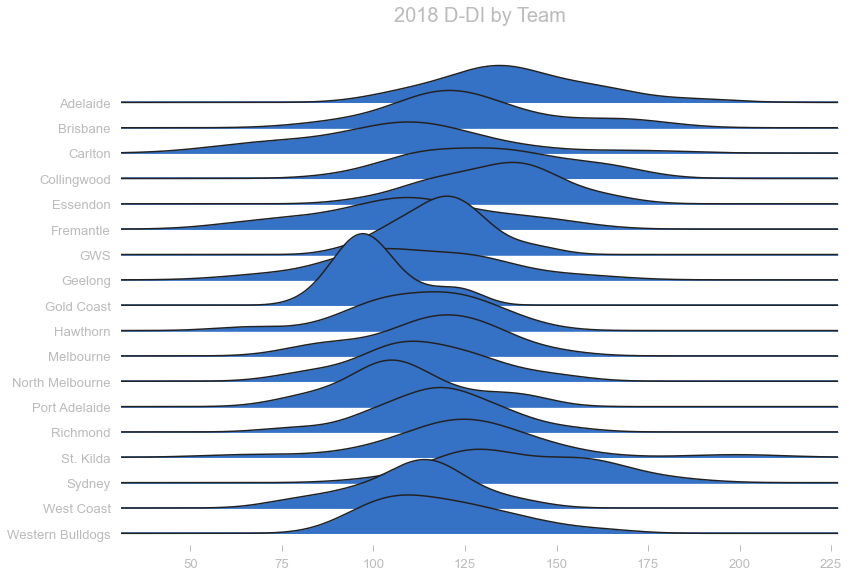

In [15]:
# Let's see if I can do a ridgeline plot here.

from joypy import joyplot

plt.figure()
# plt.set_facecolor('white')
plt.rcParams['axes.facecolor'] = 'white'
joyplot(data=season18[['Team', 'D-DI']], by='Team', figsize=(12, 8))
plt.title('2018 D-DI by Team', fontsize=20);
plt.show();

# This is nice and interesting, but it really doesn't show a very different view than the boxplot below.

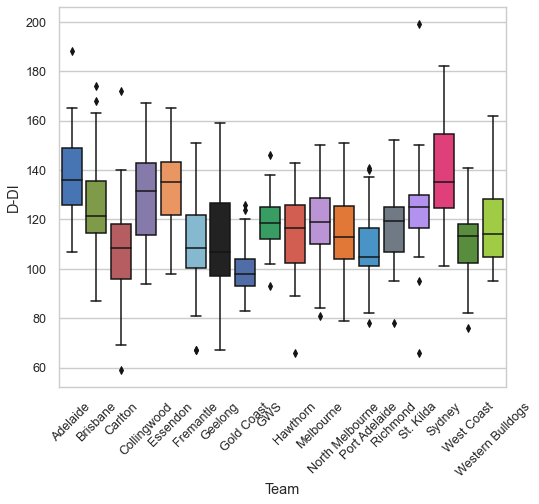

In [16]:
# season20
sns.set_style("whitegrid")
sns.boxplot(x = 'Team', y = 'D-DI', data = season18)
plt.xticks(rotation = 45);

In [17]:
# There is a ton of variability across the teams.  There's only a few times where one team's range is completely
# out of the bounds of another team, but there is still a lot of variability.  That's not a bad thing.

In [18]:
# This is unbelievable!  So now I have a multi-index for each PI with all the descriptors by year.
master_seasonPI_df.groupby('Season').describe()

D-DI                                                             \
        count        mean        std   min     25%    50%     75%    max   
Season                                                                     
2012    396.0  131.106061  48.201096  32.0  100.75  124.5  152.00  332.0   
2013    396.0  120.171717  28.800946  53.0   98.75  119.0  139.00  196.0   
2014    396.0  125.068182  32.110378  40.0  103.00  121.0  145.25  216.0   
2015    394.0  128.347716  32.289063  54.0  105.00  127.0  152.00  227.0   
2016    396.0  129.378788  28.166556  60.0  109.75  129.0  148.00  200.0   
2017    396.0  132.515152  25.496036  63.0  114.00  131.0  152.00  208.0   
2018    396.0  118.856061  21.585790  59.0  104.00  118.0  132.00  199.0   
2019    396.0  114.770202  28.335695  47.0   94.00  114.0  134.25  191.0   
2020    306.0  115.352941  30.447261  54.0   92.00  112.0  134.00  207.0   

         D-KI             ...    R-Weight         R-Age                       \
        count       mean  ...         75%    max  count       mean       std   
Season                    ...                                                  
2012    396.0  79.661616  ...  104.500000  120.0  396.0  25.717977  2.707490   
2013    396.0  73.040404  ...  104.000000  110.5  396.0  25.578436  2.368806   
2014    396.0  74.823232  ...  104.666667  113.0  396.0  26.006363  2.271391   
2015    394.0  76.159898  ...  104.000000  113.0  394.0  26.235578  2.527248   
2016    396.0  75.962121  ...  103.000000  120.0  396.0  26.427162  2.291229   
2017    396.0  78.053030  ...  103.500000  120.0  396.0  27.003677  3.176618   
2018    396.0  73.058081  ...  105.000000  120.0  396.0  27.708962  3.231167   
2019    396.0  74.353535  ...  104.000000  116.5  396.0  27.976788  3.219348   
2020    306.0  75.186275  ...  104.000000  113.0  306.0  27.757090  3.698640   

                                                
         min        25%        50%   75%   max  
Season                                          
2012    19.0  24.000000  25.000000  27.0  33.0  
2013    19.0  24.500000  25.333333  27.0  34.0  
2014    20.0  25.000000  26.500000  27.5  32.0  
2015    21.0  24.065030  27.000000  28.0  32.0  
2016    21.0  25.000000  26.000000  28.0  34.0  
2017    19.0  25.000000  27.000000  29.0  35.0  
2018    19.5  25.500000  28.000000  30.0  36.0  
2019    20.0  25.820833  28.000000  30.0  34.0  
2020    19.0  24.500000  28.000000  31.0  35.0  

[9 rows x 800 columns]

In [19]:
# Here is the same thing with the groupby on Season and Team.  This may be interesting when I get to a Monte Carlo
# simulation

master_seasonPI_df.groupby(['Season', 'Team']).describe()

D-DI                                               \
                        count        mean        std    min     25%    50%   
Season Team                                                                  
2012   Adelaide          22.0  268.545455  41.363346  190.0  242.00  260.0   
       Brisbane          22.0  137.181818  23.339393  102.0  120.25  139.5   
       Carlton           22.0  120.409091  21.753290   81.0  107.00  117.0   
       Collingwood       22.0  152.090909  29.555290  103.0  127.75  154.0   
       Essendon          22.0   95.909091  18.996012   70.0   83.25   89.0   
...                       ...         ...        ...    ...     ...    ...   
2020   Richmond          17.0   99.058824  20.586618   75.0   86.00   95.0   
       St. Kilda         17.0  127.352941  17.968518   87.0  119.00  127.0   
       Sydney            17.0  101.352941  23.005274   63.0   82.00  105.0   
       West Coast        17.0  133.000000  25.039968   88.0  127.00  133.0   
       Western Bulldogs  17.0  105.647059  21.071133   67.0   96.00  104.0   

                                        D-KI              ... R-Weight         \
                            75%    max count        mean  ...      75%    max   
Season Team                                               ...                   
2012   Adelaide          312.00  332.0  22.0  169.909091  ...   104.50  105.0   
       Brisbane          151.25  178.0  22.0   84.363636  ...   106.00  106.0   
       Carlton           127.75  178.0  22.0   73.681818  ...   103.50  104.0   
       Collingwood       172.25  206.0  22.0   93.727273  ...   108.00  108.0   
       Essendon          108.25  149.0  22.0   61.045455  ...   108.75  110.0   
...                         ...    ...   ...         ...  ...      ...    ...   
2020   Richmond          112.00  162.0  17.0   64.588235  ...   106.00  106.0   
       St. Kilda         141.00  156.0  17.0   81.352941  ...    94.00   96.5   
       Sydney            117.00  145.0  17.0   61.705882  ...    95.00  104.0   
       West Coast        147.00  175.0  17.0   96.294118  ...   109.00  109.0   
       Western Bulldogs  111.00  150.0  17.0   66.647059  ...    91.00   91.0   

                        R-Age                                             \
                        count       mean       std      min    25%   50%   
Season Team                                                                
2012   Adelaide          22.0  24.445455  0.192050  24.0000  24.50  24.5   
       Brisbane          22.0  29.840909  5.301362  19.0000  28.50  33.0   
       Carlton           22.0  23.494318  0.430388  23.0000  23.00  23.5   
       Collingwood       22.0  29.500000  2.577374  25.0000  28.75  31.0   
       Essendon          22.0  25.159091  2.321670  23.0000  23.50  23.5   
...                       ...        ...       ...      ...    ...   ...   
2020   Richmond          17.0  24.588235  0.795206  24.0000  24.00  24.0   
       St. Kilda         17.0  30.384325  2.818063  24.9875  30.50  32.0   
       Sydney            17.0  29.303571  3.216641  21.0000  29.50  31.0   
       West Coast        17.0  29.882353  0.281148  29.0000  30.00  30.0   
       Western Bulldogs  17.0  21.500000  0.000000  21.5000  21.50  21.5   

                                         
                              75%   max  
Season Team                              
2012   Adelaide          24.50000  24.8  
       Brisbane          33.00000  33.0  
       Carlton           23.78125  24.5  
       Collingwood       31.00000  31.0  
       Essendon          27.37500  31.0  
...                           ...   ...  
2020   Richmond          25.00000  26.0  
       St. Kilda         32.00000  32.0  
       Sydney            31.00000  31.0  
       West Coast        30.00000  30.0  
       Western Bulldogs  21.50000  21.5  

[162 rows x 800 columns]

In [20]:
subsample = master_seasonPI_df.groupby(['Season', 'Team']).describe()
subsample_avgmg = subsample[['D-AMG', 'F-AMG', 'M-AMG', 'R-AMG']]

subsample_avgmg

D-AMG                                             \
                        count         mean         std      min      25%   
Season Team                                                                
2012   Adelaide          22.0     0.000000    0.000000     0.00     0.00   
       Brisbane          22.0     0.000000    0.000000     0.00     0.00   
       Carlton           22.0     0.000000    0.000000     0.00     0.00   
       Collingwood       22.0     0.000000    0.000000     0.00     0.00   
       Essendon          22.0     0.000000    0.000000     0.00     0.00   
...                       ...          ...         ...      ...      ...   
2020   Richmond          17.0  1458.932353  124.856318  1322.89  1364.02   
       St. Kilda         17.0  1475.597647  139.333138  1218.58  1431.18   
       Sydney            17.0  1281.706471  184.114566   960.89  1270.76   
       West Coast        17.0  1652.699412  180.761073  1392.77  1598.10   
       Western Bulldogs  17.0  1342.727059  225.653097   657.61  1255.66   

                                                   F-AMG               ...  \
                             50%      75%      max count         mean  ...   
Season Team                                                            ...   
2012   Adelaide             0.00     0.00     0.00  22.0     0.000000  ...   
       Brisbane             0.00     0.00     0.00  22.0     0.000000  ...   
       Carlton              0.00     0.00     0.00  22.0     0.000000  ...   
       Collingwood          0.00     0.00     0.00  22.0     0.000000  ...   
       Essendon             0.00     0.00     0.00  22.0     0.000000  ...   
...                          ...      ...      ...   ...          ...  ...   
2020   Richmond          1445.67  1473.86  1686.44  17.0  2050.154706  ...   
       St. Kilda         1455.06  1562.68  1717.68  17.0  1857.821176  ...   
       Sydney            1289.79  1355.52  1670.76  17.0  1069.797059  ...   
       West Coast        1623.04  1800.37  2124.70  17.0  1260.465294  ...   
       Western Bulldogs  1364.59  1509.84  1581.20  17.0   957.487647  ...   

                           M-AMG          R-AMG                            \
                             75%      max count        mean           std   
Season Team                                                                 
2012   Adelaide             0.00     0.00  22.0    0.000000  0.000000e+00   
       Brisbane             0.00     0.00  22.0    0.000000  0.000000e+00   
       Carlton              0.00     0.00  22.0    0.000000  0.000000e+00   
       Collingwood          0.00     0.00  22.0    0.000000  0.000000e+00   
       Essendon             0.00     0.00  22.0    0.000000  0.000000e+00   
...                          ...      ...   ...         ...           ...   
2020   Richmond          1394.53  1600.67  17.0   96.637059  5.626629e+01   
       St. Kilda         1016.37  1261.45  17.0    0.000000  0.000000e+00   
       Sydney            2093.47  2190.01  17.0  101.231765  5.788148e+01   
       West Coast        1322.70  1412.48  17.0    0.000000  0.000000e+00   
       Western Bulldogs  1598.65  1745.54  17.0  392.610000  5.859286e-14   

                                                                 
                            min     25%     50%     75%     max  
Season Team                                                      
2012   Adelaide            0.00    0.00    0.00    0.00    0.00  
       Brisbane            0.00    0.00    0.00    0.00    0.00  
       Carlton             0.00    0.00    0.00    0.00    0.00  
       Collingwood         0.00    0.00    0.00    0.00    0.00  
       Essendon            0.00    0.00    0.00    0.00    0.00  
...                         ...     ...     ...     ...     ...  
2020   Richmond           53.21   53.21   53.21  128.27  181.48  
       St. Kilda           0.00    0.00    0.00    0.00    0.00  
       Sydney              0.00  132.38  132.38  132.38  132.

Now THIS is awesome.  With two lines I now have the season descriptions and the TEAM descriptions by season, so
I have an idea of how the teams are performing over time in relation to the rest of the league and to each other.

This is information that I need to operationalize, especially when I'm looking to make forward-looking predictions.

I need this variability to try and and answer the predictive questions - given this opponent with these conditions and this
spread of variability in performance, who is more likely to win?

I feel as if this has the potential to be a big deal.

In [21]:
# Just getting one row at the first multi-index
# subsample_avgmg.loc['2016','Adelaide']['D-AMG', 'mean']

# sns.boxplot(x = 'Team', y = 'M-CL', data = season20)

# thing = subsample_avgmg.loc[avgmgs, t]['D-AMG']


avgmg_seasons = [2015, 2016, 2017, 2018, 2019, 2020]

# for t in teams:
#     for avgmgs in avgmg_seasons:
#         thing = subsample_avgmg.loc[avgmgs, t]['D-AMG']
#         print(thing)

dac = []
fac = []
mac = []
rac = []
for t in teams:
    for avgmgs in avgmg_seasons:
        thingd = subsample_avgmg.loc[avgmgs, t]['D-AMG']
        thingf = subsample_avgmg.loc[avgmgs, t]['F-AMG']
        thingm = subsample_avgmg.loc[avgmgs, t]['M-AMG']
        thingr = subsample_avgmg.loc[avgmgs, t]['R-AMG']
    #         ac['Year'] = avgmgs
        dac.append(thingd)
        fac.append(thingf)
        mac.append(thingm)
        rac.append(thingr)
    
acd = pd.DataFrame(dac)
acf = pd.DataFrame(fac)
acm = pd.DataFrame(mac)
acr = pd.DataFrame(rac)
# acd['Year'] = range(2015, 2021)

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


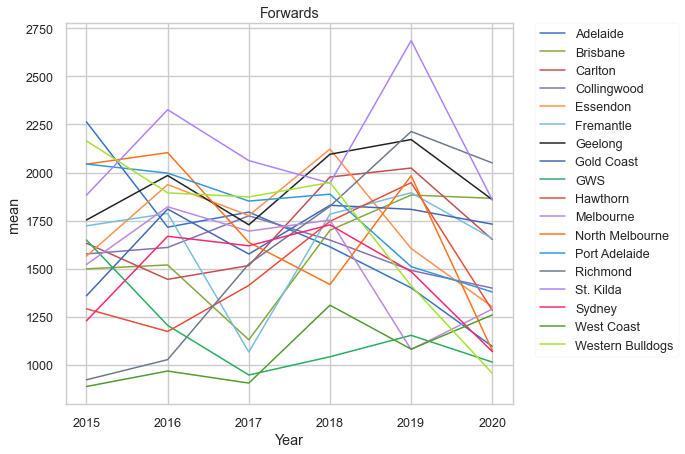

In [22]:
acf = acf.reset_index()
acf['Year'], acf['Team'] = acf['index'].str
sns.lineplot(data=acf, x = 'Year' ,y="mean", hue = 'Team').set_title('Forwards');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


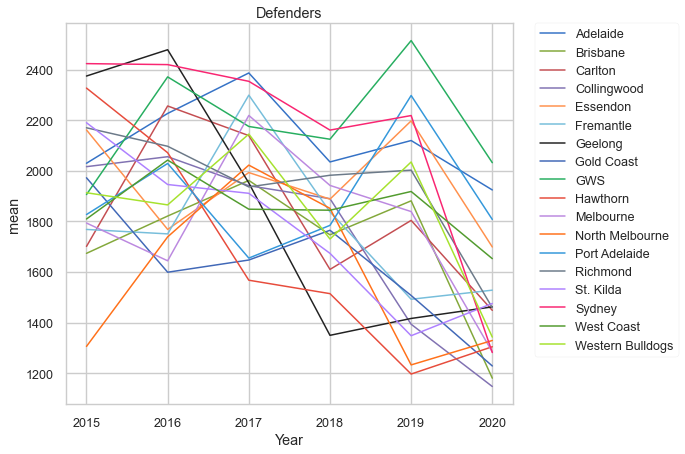

In [23]:
acd = acd.reset_index()
acd['Year'], acd['Team'] = acd['index'].str
sns.lineplot(data=acd, x = 'Year' ,y="mean", hue = 'Team').set_title('Defenders');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


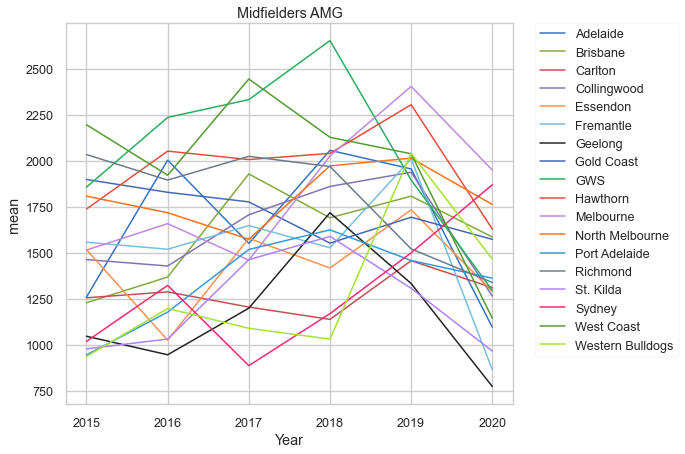

In [24]:
acm = acm.reset_index()
acm['Year'], acm['Team'] = acm['index'].str
sns.lineplot(data=acm, x = 'Year' ,y="mean", hue = 'Team').set_title('Midfielders AMG');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


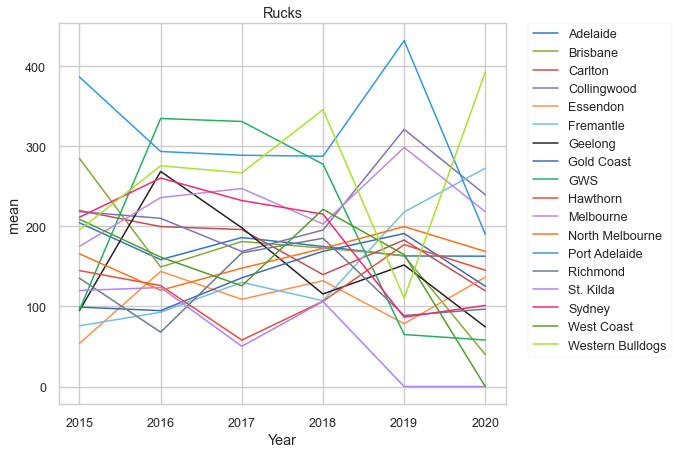

In [25]:
acr = acr.reset_index()
acr['Year'], acr['Team'] = acr['index'].str
sns.lineplot(data=acr, x = 'Year' ,y="mean", hue = 'Team').set_title('Rucks');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

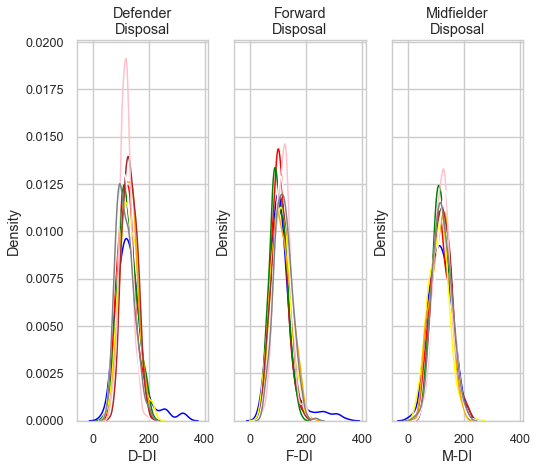

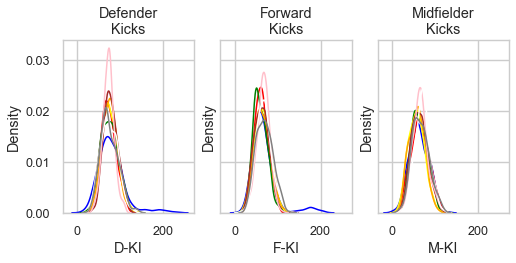

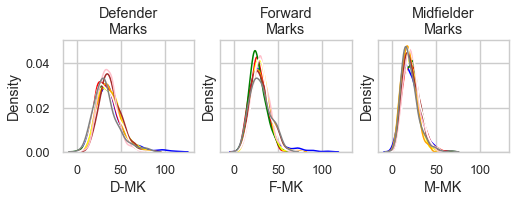

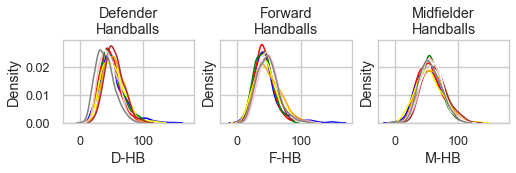

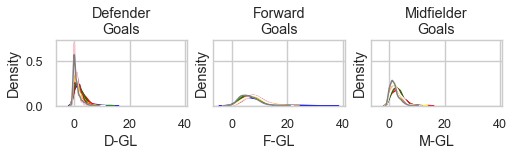

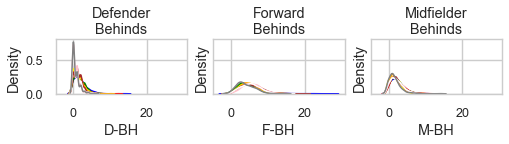

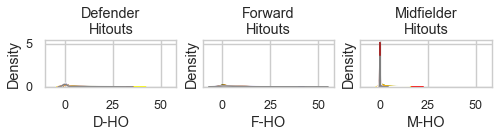

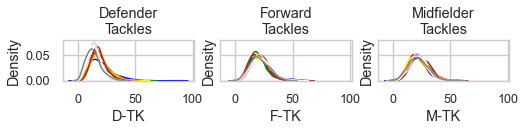

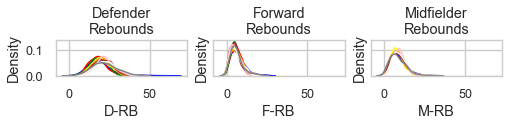

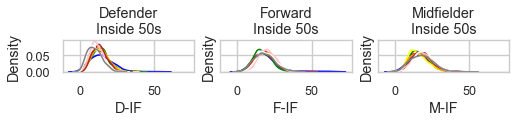

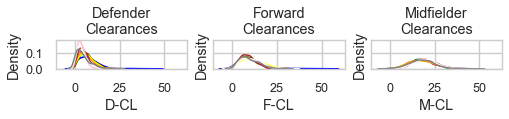

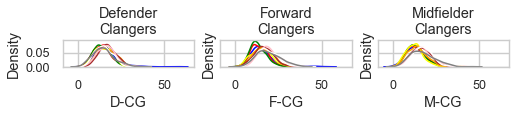

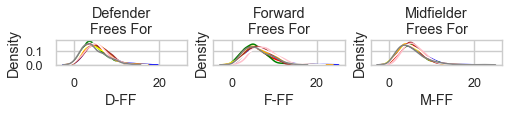

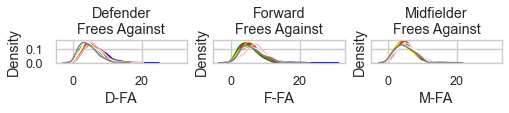

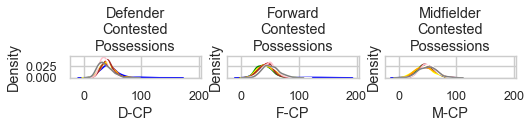

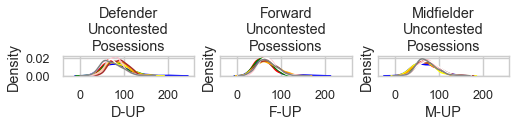

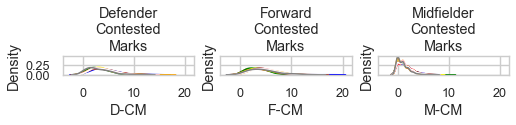

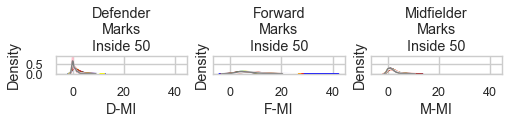

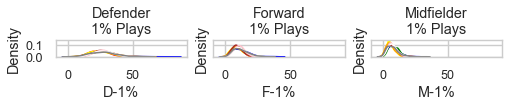

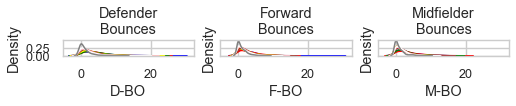

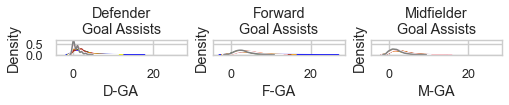

In [26]:
# So let's take a look at one stat over the entire sample size and see what that does
# This is pretty good.  Make it white to make it easier to read / see and then break it into years to look for
# variability and then just loop it through for every PI.

# Another way to look at this would be to compare each PI by each pos group within a season.

# There are a couple of really useful ways to stripe this data I think.
# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
# fig1 = plt.figure(figsize = (6,4))
# plt.gca().set_facecolor("white")

seasonlist = [season12, season13, season14, season15, season16, season17, season18, season19, season20]

colorlist = ['blue', 'red', 'green', 'yellow', 'orange', 'brown', 'pink', 'white', 'gray']

new_column_basis = ['DI', 'KI', 'MK', 'HB', 'GL', 'BH', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP', 
                    'CM', 'MI', '1%', 'BO', 'GA']

header_titles = ['Disposal', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
                'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against', 'Contested\nPossessions',
                'Uncontested\nPosessions', 'Contested\nMarks', 'Marks\nInside 50', '1% Plays', 'Bounces', 
                 'Goal Assists']

for ncb, ht in zip(enumerate(new_column_basis), header_titles):
    
    ax1 = plt.subplot(ncb[0]+1,3,1)
    plt.gca().set_facecolor("white")
    for season, svet in zip(seasonlist, colorlist):
        sns.kdeplot(season['D-'+ncb[1]],  color = svet).set_title('Defender\n'+ht)

    ax2 = plt.subplot(ncb[0]+1,3,2, sharey = ax1, sharex = ax1)
    plt.gca().set_facecolor("white")
    for season, svet in zip(seasonlist, colorlist):
        sns.kdeplot(season['F-'+ncb[1]],  color = svet).set_title('Forward\n'+ht)
    plt.setp(ax2.get_yticklabels(), visible=False);

    ax3 = plt.subplot(ncb[0]+1,3,3, sharey = ax1, sharex = ax1)
    plt.gca().set_facecolor("white")
    for season, svet in zip(seasonlist, colorlist):
        sns.kdeplot(season['M-'+ncb[1]],  color = svet).set_title('Midfielder\n'+ht)
    plt.setp(ax3.get_yticklabels(), visible=False);

#     ax4 = plt.subplot(ncb[0]+1,4,4, sharey = ax1, sharex = ax1)
#     plt.gca().set_facecolor("white")
#     for season, svet in zip(seasonlist, colorlist):
#         sns.kdeplot(season['R-'+ncb[1]],  color = svet).set_title('Ruck\n'+ht)
#     plt.setp(ax4.get_yticklabels(), visible=False)
    
    plt.show();

# Merging game data with the season-level position group PI

Now that I have all of the matches broken out by season and team, both home and away, and all of the PI by season / team / position group, I can merge the two together so that everything is aligned.  This alignment is the key step that makes the rest of the analysis possible.

First I merge the Home df with the PI data on both Club and Season so that I get the right player group PI.  These become home_list and away_list, respectively.

In [27]:
hurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Home12-20.csv'
aurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Away12-20.csv'

home = pd.read_csv(hurl)
away = pd.read_csv(aurl)

# home.Year = home.Year.astype(str) # I have made master_seasonPI_df an int dtype.
# away.Year = away.Year.astype(str)

home.replace({'Greater Western Sydney': 'GWS'}, inplace = True)
away.replace({'Greater Western Sydney': 'GWS'}, inplace = True)

home['Game'] = home['Game'].str.lstrip(string.digits)
away['Game'] = away['Game'].str.lstrip(string.digits)

home.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)
away.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)

In [28]:
home.head()

,Year,Round,Game,Home,Home Score,Venue,Home Field-H,Home State,LP-H
0,2012,round1,Game1,GWS,37,ANZ Stadium,Sydney Showground,NSW,18
1,2012,round1,Game2,Richmond,81,MCG,MCG,VIC,12
2,2012,round1,Game3,Hawthorn,137,MCG,MCG,VIC,3
3,2012,round1,Game4,Melbourne,78,MCG,MCG,VIC,13
4,2012,round1,Game5,Gold Coast,68,Metricon,Metricon,QLD,17


In [29]:
# Year and Home / Away is the same data as Season and Club in the other dataset.
# This merger puts all of the PI for each home team by year on one line and does the same for the away team.

# OK - I have some datatype issues to resolve.  This should be easy and it's probably year.
# Season is an object, Year is an int64

home_list = pd.merge(home, master_seasonPI_df, how = 'left', left_on = ['Year', 'Home', 'Round'], 
                     right_on = ['Season', 'Team', 'Round'])
away_list = pd.merge(away, master_seasonPI_df, how = 'left', left_on = ['Year', 'Away', 'Round'], 
                     right_on = ['Season', 'Team', 'Round'])

away_list.drop(['Team', 'Season'], axis = 1, inplace = True)
home_list.drop(['Team', 'Season'], axis = 1, inplace = True)

In [29]:
# len(home_gamePI_list) == len(away_gamePI_list)
len(home_list) == len(away_list)

True

What I’m really interested in is the difference between the PI for each team in a particular contest: which team “won” a particular PI.  All PI are calculated from the Home team’s perspective.  Therefore, a positive number indicates that the home team “won” and a negative number indicates that the away team “won” that PI.  The difference in the final score is, of course, the ultimate arbiter of the winner or loser, so I use that to create my target class variable.

I use this data to create some categorical variables that I think might be interesting: interstate games, where travel could be a factor; clash games, where teams that share a stadium play each other; and Relative Ladder Position (RLP) to indicate which team is better than the other team.  I created my own one-hot encoding for each binary categorical variable.

I do not create any rolling “momentum” features (performance over the last x games).  While this is prevalent on AFL’s website, and mentioned in the Young, et.al. paper, I did not create that feature.  Obviously, it would start each year – last year’s performance is irrelevant to Round 1 – and I felt that having low numbers at the start of each season might muddy the waters even further.

In [30]:
# This separates the merged descriptive data from the PIs

home_list_stats = home_list.iloc[:,9:]
away_list_stats = away_list.iloc[:,8:]

home_list_info = home_list.iloc[:,:9]
away_list_info = away_list.iloc[:,:8]


# This is the key of the analysis, I subtract the away PI from the home PI
home_away_net = home_list_stats.subtract(away_list_stats, fill_value = None)


# Here I merge the info for each match together and create the Relative Ladder Position (RLP) column
# and manually set up categorical variables, rather than using one hot encoding
info = home_list_info.merge(away_list_info, how = 'left', left_index = True, right_index = True)

info['RLP'] = info['LP-H'] - info['LP-A']

condition1 = info['Venue'] == info['Home Field-H'] 
condition2 = info['Home Field-H'] == info['Home Field-A']

condition3 = info['Venue'] != info['Home Field-H'] 
condition4 = info['Home Field-H'] != info['Home Field-A']


(info['Net Score'], info['Intrastate'], info['Same / Neutral Venue']) = \
((info['Home Score'] - info['Away Score']), np.where(info['Home State'] == info['Away State'], 0, 1), 
 np.where((condition1 & condition2) | (condition3 & condition4), 1, 0))

info['Clash'] = np.where((info['Intrastate'] == 0) & (info['Same / Neutral Venue'] == 1), 1, 0)
# info['Winner'] = np.where(info['Net Score'] >0, 'Home', 'Away')

###

conditions = [info['Net Score'] > 0, info['Net Score'] < 0, info['Net Score'] == 0]
choices = ['Home', 'Away', 'Draw']

info['Winner'] = np.select(conditions, choices, default = np.nan)

###

# Here I reconstruct and finalize the information portion of the dataframe, merge it with the PI, and then reorder it.

info = info[['Year_x','Home', 'Away', 'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP','Net Score', 'Winner']]
info = info.rename(columns = {'Year_x': 'Season'})

home_away_net_complete = home_away_net.join(info)

home_away_net_complete['Round'] = home_list_info['Round']
home_away_net_complete['Game'] = home_list_info['Game']

col = home_away_net_complete.pop('Round')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Game')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Season')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Away')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Home')
home_away_net_complete.insert(0, col.name, col)

In [31]:
specials = home_away_net_complete.columns[101:]

In [32]:
d_cols = [col for col in master_seasonPI_df.columns if col.startswith('D-')]
f_cols = [col for col in master_seasonPI_df.columns if col.startswith('F-')]
m_cols = [col for col in master_seasonPI_df.columns if col.startswith('M-')]
r_cols = [col for col in master_seasonPI_df.columns if col.startswith('R-')]

hd = home_list_stats[d_cols]
af = away_list_stats[f_cols]
hf = home_list_stats[f_cols]
ad = away_list_stats[d_cols]
new_computed_column_basis = ['DI', 'KI', 'MK', 'HB', 'GL', 'BH', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP',
                             'UP', 'CM', 'MI', '1%', 'BO', 'AMG', 'GA', 'Height', 'Weight', 'Age']

new_posgru = [hd, af, hf, ad]

for npg in new_posgru:
    npg.columns = new_computed_column_basis

hdaf = hd - af
hfad = hf - ad

In [33]:
pos_prefixes = ['HDAF', 'HFAD']
            
new_delta_headers = []
for pos in pos_prefixes:
    for stat in new_computed_column_basis:
        new_col_head = pos+'-'+stat
        new_delta_headers.append(new_col_head)
hdaf_headers = new_delta_headers[:25]
hfad_headers = new_delta_headers[25:]

hdaf.columns = hdaf_headers
hfad.columns = hfad_headers

hdaf_avmg = home_list_stats['D-AMG'] - away_list_stats['F-AMG']
hfad_avmg = home_list_stats['F-AMG'] - away_list_stats['D-AMG']

In [34]:
pos_dfs = [hdaf, hfad]

for pp, pd in zip(pos_prefixes, pos_dfs):
    pd[pp+'-TM'] = pd[pp+'-MK'] + pd[pp+'-CM'] + pd[pp+'-MI']
    pd[pp+'-TP'] = pd[pp+'-CP'] + pd[pp+'-UP']
    pd[pp+'-TT'] = pd[pp+'-FA'] + pd[pp+'-CG']
    


    
hdaf_short = hdaf[['HDAF-TM', 'HDAF-TP', 'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age']]
hfad_short = hfad[['HFAD-TM', 'HFAD-TP', 'HFAD-FF', 'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age']]

short_stack = hfad_short.join(hdaf_short) 

In [35]:
# I need to move these special columns to the end.
home_away_net_complete = home_away_net_complete.join(short_stack)

In [36]:
# Here I'm just re-ordering my columns to make it easier to normalize later.

home_away_net_complete = home_away_net_complete[['Home', 'Away', 'Season', 'Game', 'Round', 'D-DI', 'D-KI', 'D-MK', 'D-HB', 
                                                 'D-GL', 'D-BH', 'D-HO', 'D-TK', 'D-RB', 'D-IF', 'D-CL', 'D-CG', 'D-FF', 
                                                 'D-FA', 'D-CP', 'D-UP', 'D-CM', 'D-MI', 'D-1%', 'D-BO', 'D-AMG','D-GA', 'D-Height', 
                                                 'D-Weight', 'D-Age', 'F-DI', 'F-KI', 'F-MK', 'F-HB', 'F-GL', 'F-BH', 'F-HO', 
                                                 'F-TK', 'F-RB', 'F-IF', 'F-CL', 'F-CG', 'F-FF', 'F-FA', 'F-CP', 'F-UP', 
                                                 'F-CM', 'F-MI', 'F-1%', 'F-BO', 'F-AMG','F-GA', 'F-Height', 'F-Weight', 'F-Age', 
                                                 'M-DI', 'M-KI', 'M-MK', 'M-HB', 'M-GL', 'M-BH', 'M-HO', 'M-TK', 'M-RB', 
                                                 'M-IF', 'M-CL', 'M-CG', 'M-FF', 'M-FA', 'M-CP', 'M-UP', 'M-CM', 'M-MI', 
                                                 'M-1%', 'M-BO', 'M-AMG','M-GA', 'M-Height', 'M-Weight', 'M-Age', 'R-DI', 'R-KI', 
                                                 'R-MK', 'R-HB', 'R-GL', 'R-BH', 'R-HO', 'R-TK', 'R-RB', 'R-IF', 'R-CL', 
                                                 'R-CG', 'R-FF', 'R-FA', 'R-CP', 'R-UP', 'R-CM', 'R-MI', 'R-1%', 'R-BO', 'R-AMG',
                                                 'R-GA', 'R-Height', 'R-Weight', 'R-Age', 'HFAD-TM', 'HFAD-TP', 'HFAD-FF', 
                                                 'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age', 'HDAF-TM', 'HDAF-TP',
                                                 'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age', 'Intrastate',
                                                 'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]

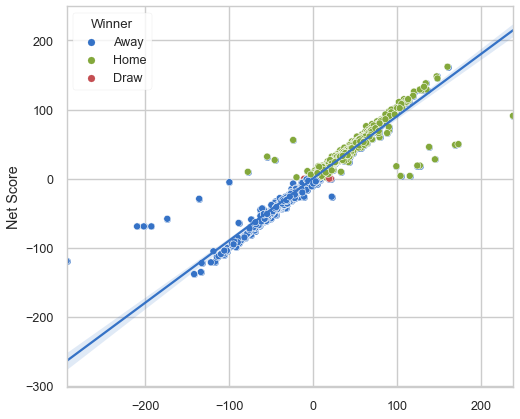

In [37]:
# Here, let's do a scatterplot of RLP vs Net Score

total_goal_difference = (home_away_net_complete['F-GL'] + home_away_net_complete['D-GL'] + home_away_net_complete['M-GL'] + home_away_net_complete['R-GL']) * 6 +\
home_away_net_complete['F-BH'] + home_away_net_complete['D-BH'] + home_away_net_complete['M-BH'] + home_away_net_complete['R-BH']

sns.regplot(data = home_away_net_complete, x=total_goal_difference, y="Net Score");
sns.scatterplot(data = home_away_net_complete, x=total_goal_difference, y="Net Score", hue = 'Winner');


# Here is the least surprising plot in the world, the most points wins and the slope is 1: it's always right.

At this point, I have all the data that I have.  I could supplement it (possibly) with distance traveled, but I'm not
sure that is critical.  I think I'm happy with this data.

Originally I wanted to reduce dimensionality, but in TensorFlow I don't think I want to reduce dimensionality.

What I want to do is cut each of these rows into the relevant position groups and run them through a ML process, then
take the output of each position group and run that through a further ML analysis before coming out with a relu prediction.

I do not want a binary judgment out of each position group - I want the most important impacts on winning for each position
group, and then I want to weigh each of those components against each other.

I have not normalized the data yet, so comparisons are a little difficult at this point.

Still, there are a couple of things that I'd like to check, like the obvious things:

1.) Does relative ladder position matter?  Does a higher seed ALWAYS beat a lower side, or is it still a crap shoot?
2.) Is there an aristocracy?  Do some teams just "always" win?  How can I encapsulate that?  That may require a different
dataset, but it should be easy.  Let's see if we can create tiers and use that to introduce some variability in the
prediction.

Maybe look at every PI for every game over the season (to date) and take a look at the variability and create a std range
based on historical performance.

That's going to come from the setup data and it's never going to change from year to year (since the 2021 season hasn't
started, everything is locked).  

The idea would be to look for PI that show a consistently high variability across season, teams, something, and then
use that to key in, or look for some explanatory value.

I broke out all of this data because it's always better to start with too much, and then sift it down to what really matters, rather than starting with too little and being unable to draw inferences.

But clearly, 78 usable features is too many.  And, because we’re looking at position PI in a game where PI flow into one another (one man's kick is another man's mark, etc.), it stands to reason that many of the features are going to be correlated to each other.  Young, et.al. suggest that an easy first step to reduce dimensionality is to look for features that are correlated with each other >.95, using Pearson’s R.

In [38]:
# By adding the _AMG suffix, I am ONLY running this analysis on years with AMG.

d_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('D-')]
f_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('F-')]
m_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('M-')]
r_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('R-')]

d_deltas = home_away_net_complete[d_cols]
f_deltas = home_away_net_complete[f_cols]
m_deltas = home_away_net_complete[m_cols]
r_deltas = home_away_net_complete[r_cols]

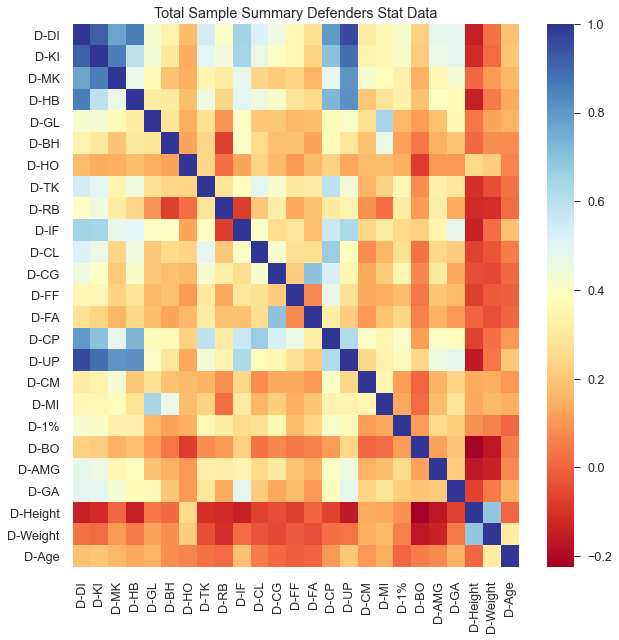

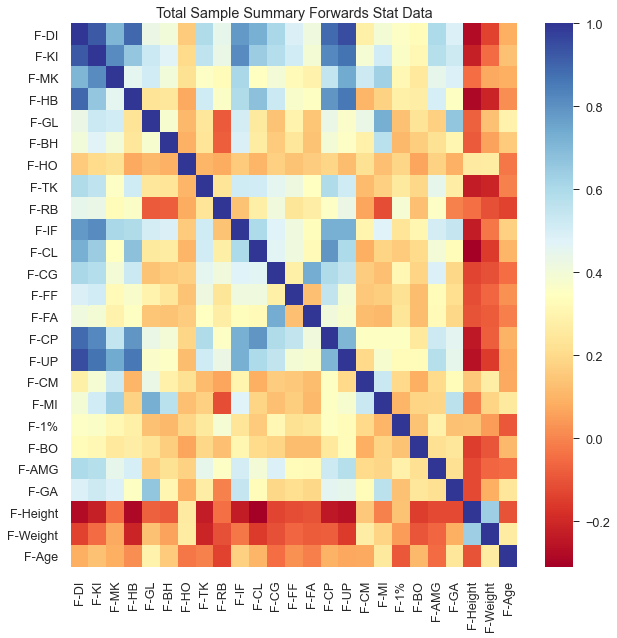

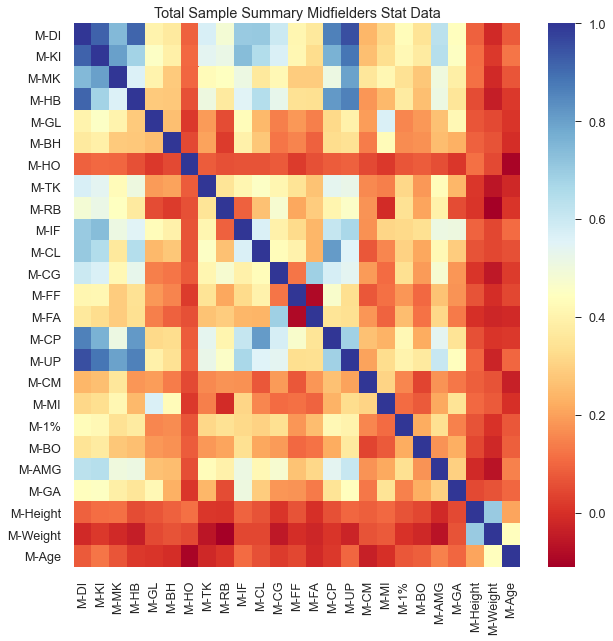

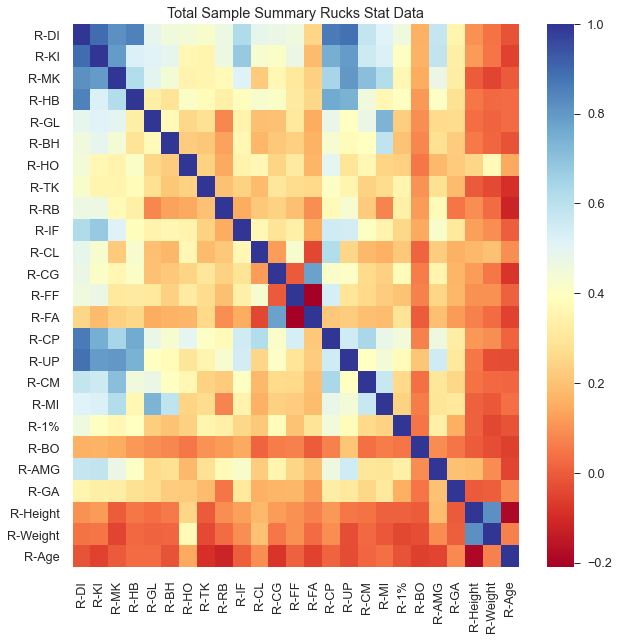

In [39]:
# plt.figure(figsize=(15,15))
# plt.title('Season Summary Stat Data')
# sns.heatmap(home_away_net.corr(), cmap = 'RdYlBu');

posgru_deltas = [d_deltas, f_deltas, m_deltas, r_deltas]
titles = ['Defenders', 'Forwards', 'Midfielders', 'Rucks']

for pg, t in zip(posgru_deltas, titles):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,10))
    plt.title('Total Sample Summary '+t+' Stat Data')
    sns.heatmap(pg.corr(), cmap = 'RdYlBu');


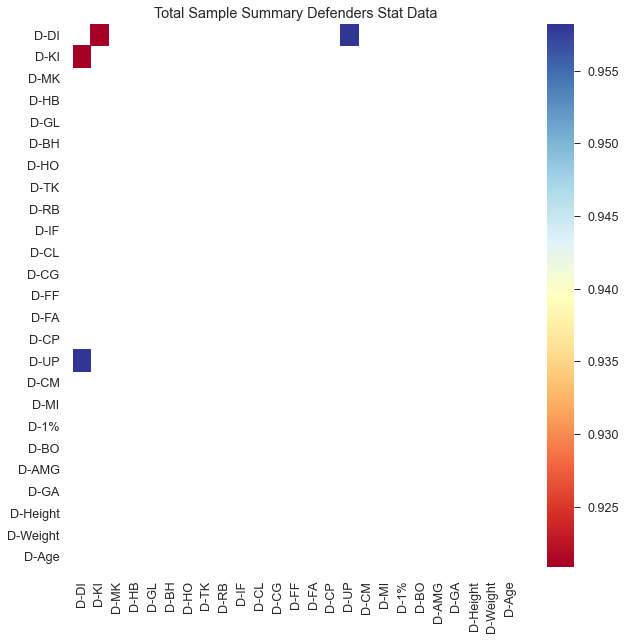

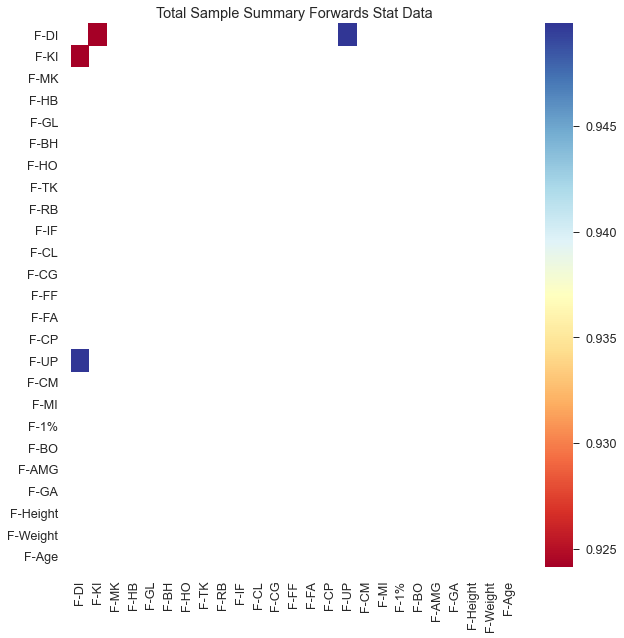

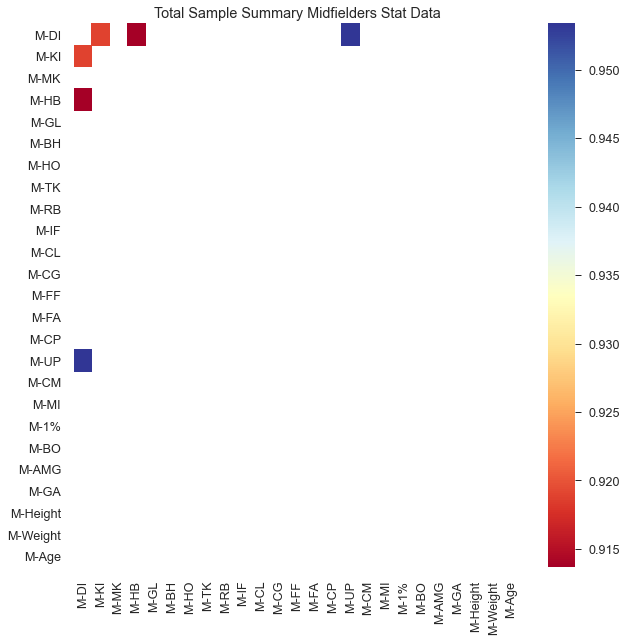

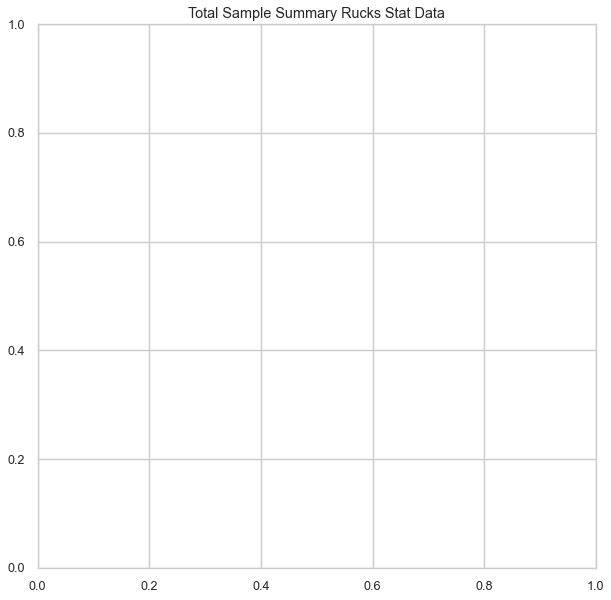

In [40]:
# plt.figure(figsize=(15,15))
# plt.title('Game PI Stat Data')
# sns.heatmap(home_away_net.corr(), cmap = 'RdYlBu');

r_criterion = .9

deltas_criteria_list = []
for pg, t in zip(posgru_deltas, titles):
    plt.figure(figsize=(10,10))
    plt.title('Total Sample Summary '+t+' Stat Data')
    corr = pg.corr()
    kot = corr[(corr>=r_criterion) & (corr < 1.0)]
    if kot.isnull().values.all() == False:
        sns.heatmap(kot, cmap = 'RdYlBu');
    else:
        pass

    deltas_criteria = np.argwhere(kot.notnull().values).tolist()
    deltas_criteria_list.append(deltas_criteria)


In [41]:
for dcl, t in zip(deltas_criteria_list, titles):
    print(t+' Deltas: ', dcl)
    

Defenders Deltas:  [[0, 1], [0, 15], [1, 0], [15, 0]]
Forwards Deltas:  [[0, 1], [0, 15], [1, 0], [15, 0]]
Midfielders Deltas:  [[0, 1], [0, 3], [0, 15], [1, 0], [3, 0], [15, 0]]
Rucks Deltas:  []


When you drill down, you see some things that make sense: there is a high correlation between having the ball and getting rid of the ball (which is a bit like noting that there is a high correlation between the numbers of pitches, balls, strikes, and hits - moving the ball is the point of the game).  Still, I'm not 100% what to do with this information.

Given that my plan is to take a deep learning approach, I don't WANT to reduce dimensionality.  I think the predictive power comes in the interplay of the PI, not in the elimination of PI.

# Preparing the PI Differential Data for Analysis

In [ ]:
# Here I want to get rid of draws, drop all scoring-related PI, and then recreate my three experimental samples:

# 2012 - 2020 with no AMG
# 2015 - 2020 with AMG
# 2015 - 2020 with no AMG

In [42]:
# Here I removed the draws / ties from consideration.  There were 11 draws over the entire sample

home_away_net_complete.drop(home_away_net_complete[home_away_net_complete['Winner'] == 'Draw'].index, inplace = True)

# Here I eliminate all goal-scoring features (Goals, Behinds, and Goal Assists)

han_cols = home_away_net_complete.columns
no_goals = [g for g in han_cols if g.endswith(('GL', 'BH', 'GA'))]

home_away_net_complete_AMG_ng = home_away_net_complete.drop(no_goals, axis = 1)
home_away_net_complete_AMG_ng

,Home,Away,Season,Game,Round,D-DI,D-KI,D-MK,D-HB,D-HO,...,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,RLP,Net Score,Winner
0,GWS,Sydney,2012,Game1,round1,-31.0,-28.0,-18.0,-3.0,0.000000,...,-4.0,0.208333,-1.666667,-1.916667,0,1,1,11,-63,Away
1,Richmond,Carlton,2012,Game2,round1,-44.0,-37.0,-20.0,-7.0,0.000000,...,-11.0,1.833333,1.333333,-2.500000,0,0,0,7,-44,Away
2,Hawthorn,Collingwood,2012,Game3,round1,38.0,15.0,12.0,23.0,2.000000,...,17.0,-1.000000,-7.583333,2.708333,0,1,1,2,22,Home
3,Melbourne,Brisbane,2012,Game4,round1,-36.0,-13.0,-25.0,-23.0,0.000000,...,17.0,5.000000,2.472222,-1.583333,1,0,0,-2,-41,Away
4,Gold Coast,Adelaide,2012,Game5,round1,-225.0,-132.0,-70.0,-93.0,-1.000000,...,-34.0,7.517857,3.089286,-1.535714,1,0,0,3,-69,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,North Melbourne,Adelaide,2020,Game5,round9,37.0,40.0,23.0,1.0,12.000000,...,5.0,4.232143,6.375000,4.553571,1,1,0,-1,69,Home
1732,St. Kilda,Sydney,2020,Game6,round9,43.0,33.0,37.0,8.0,-12.000000,...,16.0,4.208333,3.527778,0.722222,1,1,0,-10,53,Home
1733,West Coast,Geelong,2020,Game7,round9,-69.0,-55.0,-33.0,-14.0,-2.333333,...,-23.0,2.250000,-5.375000,-0.750000,1,0,0,2,9,Home
1734,Gold Coast,GWS,2020,Game8,round9,-109.0,-86.0,-52.0,-23.0,-1.000000,...,-4.0,2.500000,1.000000,1.333333,1,0,0,-2,-26,Away


Here I am going to create my 4 samples: no POSGRU separation w/o all AMG data (han0), 2012-2020 w/o all AMG data (han1), 2015-2020 with AMG data (han2), 2015 w/o AMG data (han3).

In [45]:
import pandas as pd
pi_abbrevs = ['DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP',
             'CM', 'MI', '1%', 'BO', 'AMG']

sums = []
for pia in pi_abbrevs:
    posgru_list = [g for g in home_away_net_complete_AMG_ng if g.startswith(('D', 'F', 'M', 'R')) and g.endswith((pia))]
    pi_sub = home_away_net_complete_AMG_ng[posgru_list]
    pi_sum = pi_sub.sum(axis = 1)
    sums.append(pi_sum)

new_dict = dict(zip(pi_abbrevs, sums))
new_df = pd.DataFrame(new_dict)

index_columns = home_away_net_complete_AMG_ng[['Home', 'Away', 'Season', 'Game', 'Round', 'Intrastate', 
                                               'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
new_df1 = pd.concat([new_df,index_columns], axis = 1)
han_df0 = new_df1[['Home', 'Away', 'Season', 'Game', 'Round', 'DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP',
             'CM', 'MI', '1%', 'BO', 'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]

In [46]:
han_df0

,Home,Away,Season,Game,Round,DI,KI,MK,HB,HO,...,CM,MI,1%,BO,Intrastate,Same / Neutral Venue,Clash,RLP,Net Score,Winner
0,GWS,Sydney,2012,Game1,round1,-8.0,-5.0,-6.0,-3.0,-6.0,...,-3.0,1.0,14.0,-2.0,0,1,1,11,-63,Away
1,Richmond,Carlton,2012,Game2,round1,-55.0,-41.0,-45.0,-14.0,12.0,...,-7.0,-8.0,-24.0,-3.0,0,0,0,7,-44,Away
2,Hawthorn,Collingwood,2012,Game3,round1,60.0,14.0,13.0,46.0,11.0,...,-6.0,-1.0,31.0,-2.0,0,1,1,2,22,Home
3,Melbourne,Brisbane,2012,Game4,round1,-87.0,-28.0,-42.0,-59.0,-4.0,...,-1.0,-10.0,-38.0,1.0,1,0,0,-2,-41,Away
4,Gold Coast,Adelaide,2012,Game5,round1,-450.0,-314.0,-135.0,-136.0,-63.0,...,-10.0,-23.0,-24.0,8.0,1,0,0,3,-69,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,North Melbourne,Adelaide,2020,Game5,round9,123.0,82.0,59.0,47.0,3.0,...,10.0,5.0,-7.0,1.0,1,1,0,-1,69,Home
1732,St. Kilda,Sydney,2020,Game6,round9,23.0,30.0,23.0,-15.0,-2.0,...,5.0,-1.0,-8.0,12.0,1,1,0,-10,53,Home
1733,West Coast,Geelong,2020,Game7,round9,-26.0,-22.0,-50.0,-7.0,16.0,...,-1.0,2.0,14.0,6.0,1,0,0,2,9,Home
1734,Gold Coast,GWS,2020,Game8,round9,-94.0,-51.0,-31.0,-49.0,10.0,...,-1.0,-1.0,-19.0,1.0,1,0,0,-2,-26,Away


In [47]:
han_drops = [g for g in home_away_net_complete_AMG_ng if g.endswith(('-AMG'))]

han_df1 = home_away_net_complete_AMG_ng.drop(columns = han_drops)

han_df1

,Home,Away,Season,Game,Round,D-DI,D-KI,D-MK,D-HB,D-HO,...,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,RLP,Net Score,Winner
0,GWS,Sydney,2012,Game1,round1,-31.0,-28.0,-18.0,-3.0,0.000000,...,-4.0,0.208333,-1.666667,-1.916667,0,1,1,11,-63,Away
1,Richmond,Carlton,2012,Game2,round1,-44.0,-37.0,-20.0,-7.0,0.000000,...,-11.0,1.833333,1.333333,-2.500000,0,0,0,7,-44,Away
2,Hawthorn,Collingwood,2012,Game3,round1,38.0,15.0,12.0,23.0,2.000000,...,17.0,-1.000000,-7.583333,2.708333,0,1,1,2,22,Home
3,Melbourne,Brisbane,2012,Game4,round1,-36.0,-13.0,-25.0,-23.0,0.000000,...,17.0,5.000000,2.472222,-1.583333,1,0,0,-2,-41,Away
4,Gold Coast,Adelaide,2012,Game5,round1,-225.0,-132.0,-70.0,-93.0,-1.000000,...,-34.0,7.517857,3.089286,-1.535714,1,0,0,3,-69,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,North Melbourne,Adelaide,2020,Game5,round9,37.0,40.0,23.0,1.0,12.000000,...,5.0,4.232143,6.375000,4.553571,1,1,0,-1,69,Home
1732,St. Kilda,Sydney,2020,Game6,round9,43.0,33.0,37.0,8.0,-12.000000,...,16.0,4.208333,3.527778,0.722222,1,1,0,-10,53,Home
1733,West Coast,Geelong,2020,Game7,round9,-69.0,-55.0,-33.0,-14.0,-2.333333,...,-23.0,2.250000,-5.375000,-0.750000,1,0,0,2,9,Home
1734,Gold Coast,GWS,2020,Game8,round9,-109.0,-86.0,-52.0,-23.0,-1.000000,...,-4.0,2.500000,1.000000,1.333333,1,0,0,-2,-26,Away


In [48]:
han_df2 = home_away_net_complete_AMG_ng[home_away_net_complete_AMG_ng['Season']>2014]

han_df2

,Home,Away,Season,Game,Round,D-DI,D-KI,D-MK,D-HB,D-HO,...,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,RLP,Net Score,Winner
594,Carlton,Richmond,2015,Game1,round1,-43.0,-13.0,-3.0,-30.0,5.000000,...,1.0,-2.050000,-1.950000,0.850000,0,0,0,5,-27,Away
595,Melbourne,Gold Coast,2015,Game2,round1,-32.0,-24.0,-9.0,-8.0,3.000000,...,6.0,2.071429,7.928571,4.142857,1,0,0,5,26,Home
596,Sydney,Essendon,2015,Game3,round1,-1.0,-6.0,-7.0,5.0,-1.000000,...,-18.0,2.017857,1.428571,0.767857,1,0,0,-6,12,Home
597,Brisbane,Collingwood,2015,Game4,round1,-22.0,1.0,9.0,-23.0,-1.000000,...,2.0,5.714286,-1.857143,-1.285714,1,0,0,4,-12,Away
598,Western Bulldogs,West Coast,2015,Game5,round1,23.0,11.0,-2.0,12.0,0.000000,...,0.0,-2.690476,-0.452381,3.714286,1,0,0,5,10,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,North Melbourne,Adelaide,2020,Game5,round9,37.0,40.0,23.0,1.0,12.000000,...,5.0,4.232143,6.375000,4.553571,1,1,0,-1,69,Home
1732,St. Kilda,Sydney,2020,Game6,round9,43.0,33.0,37.0,8.0,-12.000000,...,16.0,4.208333,3.527778,0.722222,1,1,0,-10,53,Home
1733,West Coast,Geelong,2020,Game7,round9,-69.0,-55.0,-33.0,-14.0,-2.333333,...,-23.0,2.250000,-5.375000,-0.750000,1,0,0,2,9,Home
1734,Gold Coast,GWS,2020,Game8,round9,-109.0,-86.0,-52.0,-23.0,-1.000000,...,-4.0,2.500000,1.000000,1.333333,1,0,0,-2,-26,Away


In [49]:
han_df3 = han_df1[han_df1['Season'] > 2014]

han_df3

,Home,Away,Season,Game,Round,D-DI,D-KI,D-MK,D-HB,D-HO,...,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,RLP,Net Score,Winner
594,Carlton,Richmond,2015,Game1,round1,-43.0,-13.0,-3.0,-30.0,5.000000,...,1.0,-2.050000,-1.950000,0.850000,0,0,0,5,-27,Away
595,Melbourne,Gold Coast,2015,Game2,round1,-32.0,-24.0,-9.0,-8.0,3.000000,...,6.0,2.071429,7.928571,4.142857,1,0,0,5,26,Home
596,Sydney,Essendon,2015,Game3,round1,-1.0,-6.0,-7.0,5.0,-1.000000,...,-18.0,2.017857,1.428571,0.767857,1,0,0,-6,12,Home
597,Brisbane,Collingwood,2015,Game4,round1,-22.0,1.0,9.0,-23.0,-1.000000,...,2.0,5.714286,-1.857143,-1.285714,1,0,0,4,-12,Away
598,Western Bulldogs,West Coast,2015,Game5,round1,23.0,11.0,-2.0,12.0,0.000000,...,0.0,-2.690476,-0.452381,3.714286,1,0,0,5,10,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,North Melbourne,Adelaide,2020,Game5,round9,37.0,40.0,23.0,1.0,12.000000,...,5.0,4.232143,6.375000,4.553571,1,1,0,-1,69,Home
1732,St. Kilda,Sydney,2020,Game6,round9,43.0,33.0,37.0,8.0,-12.000000,...,16.0,4.208333,3.527778,0.722222,1,1,0,-10,53,Home
1733,West Coast,Geelong,2020,Game7,round9,-69.0,-55.0,-33.0,-14.0,-2.333333,...,-23.0,2.250000,-5.375000,-0.750000,1,0,0,2,9,Home
1734,Gold Coast,GWS,2020,Game8,round9,-109.0,-86.0,-52.0,-23.0,-1.000000,...,-4.0,2.500000,1.000000,1.333333,1,0,0,-2,-26,Away


In [50]:
# Here I want to check and make sure that AMG is NOT in d1, but is in d2 and d3

d1_cols = han_df1.columns
d2_cols = han_df2.columns
d3_cols = han_df3.columns

dcols = [d1_cols, d2_cols, d3_cols]
dcols_str = ['d1_cols', 'd2_cols', 'd3_cols']

for dc, dcs in zip(dcols, dcols_str):
    if ('F-AMG' and 'D-AMG' and 'M-AMG' and 'R-AMG') in dc:
        print(dcs+' has AMG column')
    else:
        print(dcs+' does not have the AMG column')
    
    if ('F-GL' and 'D-GA' and 'M-BH' and 'R-GL') in dc:
        print(dcs+' still has Goal columns')
    else:
        print(dcs+' does NOT have the Goal columns')


d1_cols does not have the AMG column
d1_cols does NOT have the Goal columns
d2_cols has AMG column
d2_cols does NOT have the Goal columns
d3_cols does not have the AMG column
d3_cols does NOT have the Goal columns


In [51]:
# Here I am just checking da numbas of the target variable.

d1 = han_df1['Winner'].value_counts()
d2 = han_df2['Winner'].value_counts()

d1_h = (d1[0] / han_df1['Winner'].count()) * 100
d2_h = (d2[0] / han_df2['Winner'].count()) * 100


print('The df1 home win distribution is: ', d1_h, 100 - d1_h)
print('\nThe df2 and df3 home win distribtion is: ', d2_h, 100 - d2_h)

The df1 home win distribution is:  56.405797101449274 43.594202898550726

The df2 and df3 home win distribtion is:  56.79012345679012 43.20987654320988


In [ ]:
# Essentially, the distribution of home wins and away wins is the same in the two samples.

# Normalization and X_train / X_test split

In [52]:
# First I define the X and Y variables and transform the Y via LabelEncoder()
# I have done all of my imports at the start of the worksheet

X0 = han_df0.iloc[:, 5:-2]
X1 = han_df1.iloc[:, 5:-2]
X2 = han_df2.iloc[:, 5:-2]
X3 = han_df3.iloc[:, 5:-2]

col0 = X0.pop('RLP')
X0.insert(0, col0.name, col0)

col1 = X1.pop('RLP')
X1.insert(0, col1.name, col1)

col2 = X2.pop('RLP')
X2.insert(0, col2.name, col2)

col3 = X3.pop('RLP')
X3.insert(0, col3.name, col3)

y0 = han_df0.iloc[:,-1]
y1 = han_df1.iloc[:,-1]
y2 = han_df2.iloc[:,-1]
y3 = han_df3.iloc[:,-1]
# z = home_away_net_complete_AMG_ng.iloc[:,-2]

le = LabelEncoder()
y0 = le.fit_transform(y0)
y1 = le.fit_transform(y1)
y2 = le.fit_transform(y2)
y3 = le.fit_transform(y3)

le.transform(['Home', 'Away'])

# # Here, 1 is a Home Win, 0 is an Away Win / Home Loss

array([1, 0], dtype=int64)

In [53]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.20, stratify = y0, shuffle = True, random_state = 5)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.20, stratify = y1, shuffle = True, random_state = 5)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.20, stratify = y2, shuffle = True, random_state = 5)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.20, stratify = y3, shuffle = True, random_state = 5)

In [ ]:
# So, the question at this point is this: do I want to keep the random_state across the samples or not?

# For right now, I am going to, but I don't know if I will in the future.

# It really doesn't matter.  The ratios stay the same no matter what I do.

In [54]:
# Here I am just verifying that the home / loss wins are approximately the same - it's just a sanity check.

samples = ['Sample 0','Sample 1', 'Sample 2', 'Sample 3']
trains = [y0_train, y1_train, y2_train, y3_train]
tests = [y0_test, y1_test, y2_test, y3_test]

for train, test, sample in zip(trains, tests, samples):
    unique_train, counts_train = np.unique(train, return_counts = True)
    train_ratio = dict(zip(unique_train, counts_train))

    unique_test, counts_test = np.unique(test, return_counts = True)
    test_ratio = dict(zip(unique_test, counts_test))

    percent_home_win_train = train_ratio[1] / (train_ratio[0] + train_ratio[1]) * 100
    percent_home_win_test = test_ratio[1] / (test_ratio[0] + test_ratio[1]) * 100

    print('Season summary ratio in '+ sample+': ', percent_home_win_train, percent_home_win_test)

# When I work on X1 / y1 I get 56.3 / 56.52 on the split.  If I do X2, X3 / y2, y3

Season summary ratio in Sample 0:  56.376811594202906 56.52173913043478
Season summary ratio in Sample 1:  56.376811594202906 56.52173913043478
Season summary ratio in Sample 2:  56.780595369349506 56.82819383259912
Season summary ratio in Sample 3:  56.780595369349506 56.82819383259912


In [55]:
X0_test

# I'm breaking down somewhere I shouldn't have that many columns in X0

,RLP,DI,KI,MK,HB,HO,TK,RB,IF,CL,...,FA,CP,UP,CM,MI,1%,BO,Intrastate,Same / Neutral Venue,Clash
1363,-13,54.0,-4.0,-12.0,58.0,-3.0,-6.0,-6.0,17.0,0.0,...,-8.0,22.0,55.0,-1.0,8.0,-13.0,0.0,1,0,0
1151,-2,-18.0,-9.0,-3.0,-9.0,-11.0,-6.0,28.0,-30.0,-3.0,...,0.0,-19.0,-10.0,-2.0,0.0,7.0,1.0,0,0,0
69,-7,51.0,2.0,8.0,49.0,25.0,-22.0,18.0,-8.0,5.0,...,2.0,20.0,20.0,11.0,7.0,-4.0,4.0,1,0,0
227,-8,-3.0,-13.0,-12.0,10.0,-1.0,17.0,4.0,6.0,6.0,...,-2.0,-2.0,-13.0,1.0,1.0,-3.0,15.0,0,0,0
1229,7,26.0,27.0,27.0,-1.0,17.0,-14.0,-8.0,-3.0,-9.0,...,-9.0,-26.0,41.0,-5.0,-6.0,-5.0,-13.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,15,43.0,39.0,50.0,4.0,-8.0,15.0,11.0,-3.0,-2.0,...,-5.0,-1.0,55.0,0.0,7.0,-20.0,3.0,0,1,1
967,-3,80.0,11.0,7.0,69.0,8.0,3.0,-32.0,31.0,15.0,...,-16.0,21.0,63.0,5.0,5.0,9.0,-1.0,1,0,0
908,5,13.0,-13.0,-4.0,26.0,10.0,-5.0,-6.0,8.0,12.0,...,0.0,45.0,-18.0,16.0,6.0,-6.0,-3.0,1,0,0
621,-7,-42.0,-17.0,8.0,-25.0,-66.0,24.0,3.0,-10.0,-28.0,...,-3.0,-18.0,-21.0,2.0,-4.0,7.0,0.0,1,0,0


In [56]:
X0_train_scaled = []
X1_train_scaled = []
X2_train_scaled = []
X3_train_scaled = []

X_train_str = ['X0_train','X1_train', 'X2_train', 'X3_train']
X_trains = [X0_train, X1_train, X2_train, X3_train]
X_tests = [X0_test, X1_test, X2_test, X3_test]
X_train_scaleds = [X0_train_scaled, X1_train_scaled, X2_train_scaled, X3_train_scaled]


for X_train_st, X_train, X_test in zip(X_train_str, X_trains, X_tests):
    columns = list(X_train.columns)

    keeper_columns = columns[:-4]

    keeper_data = X_train[keeper_columns]

    ct = ColumnTransformer([('somename', StandardScaler(), keeper_columns)], remainder = 'passthrough')

# # Here all of my data is scaled and transformed
    
    if X_train_st == 'X0_train':
        X0_train_scaled = ct.fit_transform(X_train[columns])
        X0_test_scaled = ct.transform(X_test[columns])    
    elif X_train_st == 'X1_train':
        X1_train_scaled = ct.fit_transform(X_train[columns])
        X1_test_scaled = ct.transform(X_test[columns])
    elif X_train_st == 'X2_train':
        X2_train_scaled = ct.fit_transform(X_train[columns])
        X2_test_scaled = ct.transform(X_test[columns])
    else:
        X3_train_scaled = ct.fit_transform(X_train[columns])
        X3_test_scaled = ct.transform(X_test[columns])
        

In [57]:
scaled_columns = X0_test.columns.to_list()
X0_train_scaled_df = pd.DataFrame(X0_train_scaled, columns = scaled_columns)
X0_test_scaled_df = pd.DataFrame(data = X0_test_scaled, columns = scaled_columns)
y0_train_df = pd.DataFrame(y0_train)
y0_test_df = pd.DataFrame(y0_test)

X0_train_scaled_df['Winner'] = y0_train_df[0]
X0_test_scaled_df['Winner'] = y0_test_df[0]


master_scaled_df0 = X0_train_scaled_df.append(X0_test_scaled_df)

master_scaled_df0.head()

,RLP,DI,KI,MK,HB,HO,TK,RB,IF,CL,...,CP,UP,CM,MI,1%,BO,Intrastate,Same / Neutral Venue,Clash,Winner
0,-1.402958,0.764408,0.942099,1.033820,0.290834,0.389262,1.339971,-2.090352,1.848870,1.031433,...,0.325613,0.977669,0.091349,0.964569,0.120996,1.0,1.0,0.0,0.0,1
1,-0.848484,-2.498309,-2.518791,-3.253895,-1.601228,-0.501239,-1.771087,0.923949,-1.208578,-0.334398,...,-1.055289,-2.900596,-1.292040,-1.259964,0.277707,-2.0,0.0,1.0,1.0,0
2,1.369408,0.322730,-0.144975,-1.012589,0.783288,1.646440,-0.778196,-2.090352,1.613682,1.304599,...,1.351425,-0.073450,0.610119,0.686502,0.356062,0.0,1.0,0.0,0.0,1
3,-1.818812,-0.175938,-0.633050,-0.752728,0.420427,-1.706035,-1.109160,-0.298065,0.026160,0.211935,...,-0.463474,-0.091572,-1.119116,-0.147698,1.296325,2.0,0.0,1.0,1.0,1
4,0.121843,-1.045046,-1.032383,-0.590314,-0.694075,-0.344092,-0.976775,-1.520079,0.614131,-0.698619,...,-0.897472,-0.997709,0.264272,0.825536,-1.602819,-6.0,1.0,0.0,0.0,0


In [58]:
# this is just for my eyeballs, a sanity check
import pandas as pd
scaled_columns = X1_test.columns.to_list()
X1_train_scaled_df = pd.DataFrame(X1_train_scaled, columns = scaled_columns)
X1_test_scaled_df = pd.DataFrame(data = X1_test_scaled, columns = scaled_columns)
y1_train_df = pd.DataFrame(y1_train)
y1_test_df = pd.DataFrame(y1_test)

X1_train_scaled_df['Winner'] = y1_train_df[0]
X1_test_scaled_df['Winner'] = y1_test_df[0]


master_scaled_df1 = X1_train_scaled_df.append(X1_test_scaled_df)

master_scaled_df1.head()

,RLP,D-DI,D-KI,D-MK,D-HB,D-HO,D-TK,D-RB,D-IF,D-CL,...,HDAF-TP,HDAF-FF,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,Winner
0,-1.402958,1.430583,1.371109,1.777717,1.153952,0.587753,1.513390,-0.811453,2.316076,0.131874,...,0.913196,1.445626,-0.166339,1.165918,0.683226,4.177778,1.0,0.0,0.0,1
1,-0.848484,-0.972127,-1.244912,-1.349535,-0.370914,-0.020536,-1.476902,1.129471,-1.182630,-0.047599,...,-0.911828,-1.773256,0.458646,-1.306062,-1.861576,-0.178571,0.0,1.0,1.0,0
2,1.369408,0.326636,-0.259657,-1.190522,1.109103,-0.831588,-0.126448,-1.242769,1.383088,1.926607,...,0.808310,-0.040012,1.262199,-1.383171,-0.554217,0.555556,1.0,0.0,0.0,1
3,-1.818812,0.131821,-0.463503,-0.978505,0.884858,-0.223299,0.066474,0.159009,-0.133018,-0.227073,...,0.116059,-1.030437,0.637214,1.875752,2.374266,4.500000,0.0,1.0,1.0,1
4,0.121843,0.802848,1.269186,0.505615,-0.012122,-0.020536,1.224007,0.051180,2.316076,-0.047599,...,0.220946,-0.040012,0.190795,0.618012,0.699142,0.138889,1.0,0.0,0.0,0


In [59]:
scaled_columns = X2_test.columns.to_list()
X2_train_scaled_df = pd.DataFrame(X2_train_scaled, columns = scaled_columns)
X2_test_scaled_df = pd.DataFrame(data = X2_test_scaled, columns = scaled_columns)
y2_train_df = pd.DataFrame(y2_train)
y2_test_df = pd.DataFrame(y2_test)

X2_train_scaled_df['Winner'] = y2_train_df[0]
X2_test_scaled_df['Winner'] = y2_test_df[0]


master_scaled_df2 = X2_train_scaled_df.append(X2_test_scaled_df)

master_scaled_df2.head()

,RLP,D-DI,D-KI,D-MK,D-HB,D-HO,D-TK,D-RB,D-IF,D-CL,...,HDAF-TP,HDAF-FF,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,Winner
0,0.908077,0.352192,0.398927,0.017465,0.190533,0.031887,1.714631,0.471593,0.437827,0.173964,...,0.534216,1.727052,-0.057742,-0.141191,-0.062416,2.678571,1.0,0.0,0.0,1
1,1.856487,-1.067314,-0.556568,-0.707656,-1.409595,-0.146103,0.201188,-1.586804,0.437827,-0.636231,...,0.332765,-0.270635,-0.324040,0.694902,0.637229,-2.571429,1.0,1.0,0.0,1
2,0.230642,0.327717,-0.174370,-0.428763,0.869376,0.031887,0.309291,1.500792,-0.629671,0.173964,...,1.384787,-1.019767,0.119790,-2.601497,-0.908256,2.821429,1.0,0.0,0.0,1
3,-1.395203,1.404584,1.354421,0.965701,1.063331,2.523753,0.741704,1.089112,0.437827,0.984159,...,-0.182054,0.228787,-0.412806,-1.134908,-0.503900,1.861111,1.0,0.0,0.0,1
4,0.095155,-0.088345,0.093169,0.854144,-0.294354,-2.281989,-0.123121,-0.454686,-1.563732,-0.028585,...,-1.905578,-2.018610,-0.412806,0.552355,1.288838,1.571429,0.0,1.0,1.0,0


In [60]:
scaled_columns = X3_test.columns.to_list()
X3_train_scaled_df = pd.DataFrame(X3_train_scaled, columns = scaled_columns)
X3_test_scaled_df = pd.DataFrame(data = X3_test_scaled, columns = scaled_columns)
y3_train_df = pd.DataFrame(y3_train)
y3_test_df = pd.DataFrame(y3_test)

X3_train_scaled_df['Winner'] = y3_train_df[0]
X3_test_scaled_df['Winner'] = y3_test_df[0]


master_scaled_df3 = X3_train_scaled_df.append(X3_test_scaled_df)

master_scaled_df3.head()

,RLP,D-DI,D-KI,D-MK,D-HB,D-HO,D-TK,D-RB,D-IF,D-CL,...,HDAF-TP,HDAF-FF,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,Winner
0,0.908077,0.352192,0.398927,0.017465,0.190533,0.031887,1.714631,0.471593,0.437827,0.173964,...,0.534216,1.727052,-0.057742,-0.141191,-0.062416,2.678571,1.0,0.0,0.0,1
1,1.856487,-1.067314,-0.556568,-0.707656,-1.409595,-0.146103,0.201188,-1.586804,0.437827,-0.636231,...,0.332765,-0.270635,-0.324040,0.694902,0.637229,-2.571429,1.0,1.0,0.0,1
2,0.230642,0.327717,-0.174370,-0.428763,0.869376,0.031887,0.309291,1.500792,-0.629671,0.173964,...,1.384787,-1.019767,0.119790,-2.601497,-0.908256,2.821429,1.0,0.0,0.0,1
3,-1.395203,1.404584,1.354421,0.965701,1.063331,2.523753,0.741704,1.089112,0.437827,0.984159,...,-0.182054,0.228787,-0.412806,-1.134908,-0.503900,1.861111,1.0,0.0,0.0,1
4,0.095155,-0.088345,0.093169,0.854144,-0.294354,-2.281989,-0.123121,-0.454686,-1.563732,-0.028585,...,-1.905578,-2.018610,-0.412806,0.552355,1.288838,1.571429,0.0,1.0,1.0,0


# Ttest - identify features that influence the outcome

This analysis was in https://www.kaggle.com/aaronl87/predicting-winner-and-afl-fantasy-points, and I thought it was interesting, insofar as it uses the t-test statistic to provide some sense of feature importance in this big undifferentiated list.

In [ ]:
# 2/25/21 This is where I left off.  I need to create some loops here to try and create these scales and do these
# graphs

0.0012182118299312243


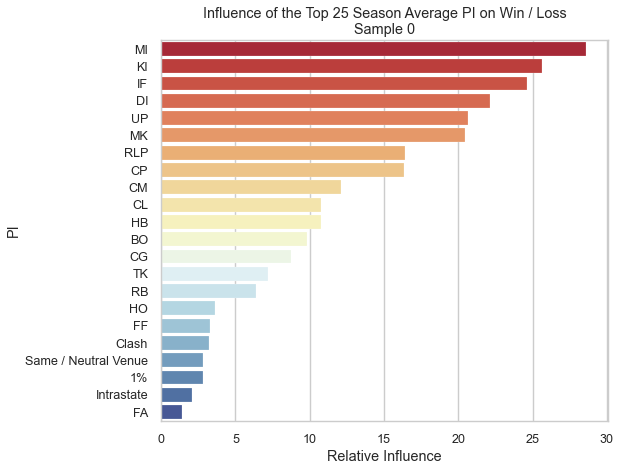

0.0012182118299312243


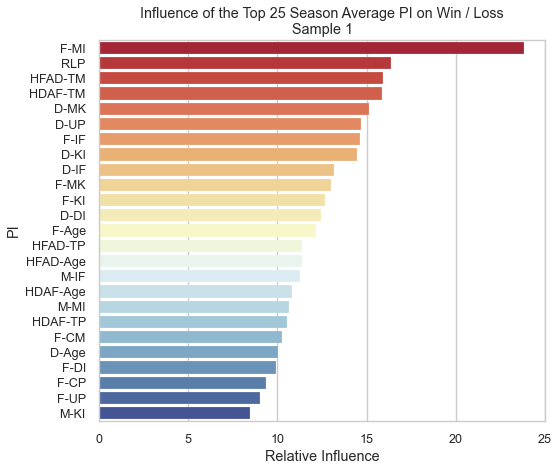

0.02649376945545532


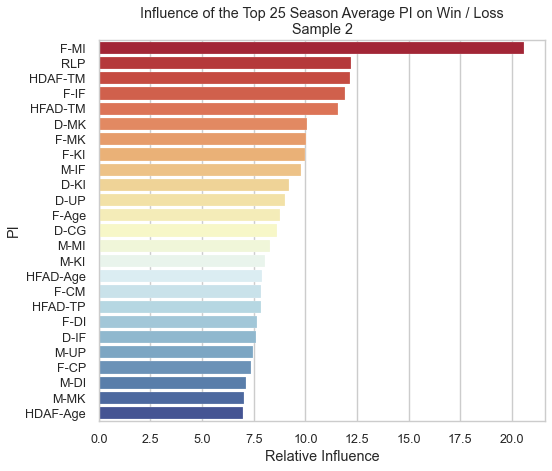

0.02649376945545532


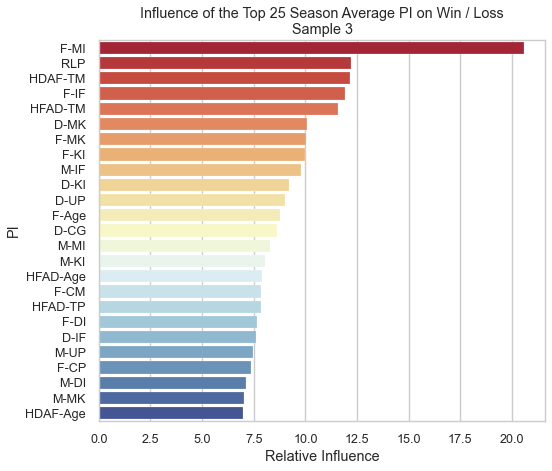

In [61]:
# m is the number of columns
scaled_dfs = [master_scaled_df0, master_scaled_df1, master_scaled_df2, master_scaled_df3]
str_dfs = ['Sample 0', 'Sample 1', 'Sample 2', 'Sample 3']
for sdf, s_df in zip(scaled_dfs, str_dfs):
    number_list = sdf.select_dtypes(include = 'number').columns
    number_list = number_list[:-1]
# Home = 1, Away = 0
    hw = sdf[sdf.Winner == 1]
    aw = sdf[sdf.Winner == 0]

    # This analysis is copied from https://www.kaggle.com/aaronl87/predicting-winner-and-afl-fantasy-points

    series_list = []
    

    for m in range(len(number_list)):
        test_stat1, p_value1 = ttest_ind(hw[number_list[m]], aw[number_list[m]])
        series_list.append([number_list[m], test_stat1])

    hanet_stat = pd.DataFrame(series_list, columns = ['column_name', 'test_stat_mean'])
    hanet_stat.set_index('column_name', inplace = True)
    hanet_stat.replace([np.inf, -np.inf], np.nan, inplace = True)
    hanet_stat.dropna().abs().sort_values('test_stat_mean', ascending = False)['test_stat_mean']

    hanet_abs = hanet_stat['test_stat_mean'].abs()
    hanet_subset = hanet_abs.sort_values( ascending = False)

    hanet_subset_1 = hanet_subset[:25]
    hanet_subset_1 = hanet_subset_1.reset_index()
    hanet_subset_1.rename(columns = {'column_name': 'PI', 'test_stat_mean': 'Relative Influence'}, inplace = True)
    
    print(p_value1)

    sns.barplot(x = 'Relative Influence', y = 'PI', data = hanet_subset_1, palette = 'RdYlBu').set_title('Influence of the Top 25 Season Average PI on Win / Loss\n'+s_df);
    plt.show();

In [62]:
def explained_variance(xtrain_scaled_df, xtest_scaled_df):
    D_train_subset, D_test_subset = [col for col in xtrain_scaled_df if col.startswith('D-')], [col for col in xtest_scaled_df if col.startswith('D-')]
    D_train_scaled, D_test_scaled = xtrain_scaled_df[D_train_subset], xtest_scaled_df[D_test_subset]

    F_train_subset, F_test_subset = [col for col in xtrain_scaled_df if col.startswith('F-')], [col for col in xtest_scaled_df if col.startswith('F-')]
    F_train_scaled, F_test_scaled = xtrain_scaled_df[F_train_subset], xtest_scaled_df[F_test_subset]

    M_train_subset, M_test_subset = [col for col in xtrain_scaled_df if col.startswith('M-')], [col for col in xtest_scaled_df if col.startswith('M-')]
    M_train_scaled, M_test_scaled = xtrain_scaled_df[M_train_subset], xtest_scaled_df[M_test_subset]

    R_train_subset, R_test_subset = [col for col in xtrain_scaled_df if col.startswith('R-')], [col for col in xtest_scaled_df if col.startswith('R-')]
    R_train_scaled, R_test_scaled = xtrain_scaled_df[R_train_subset], xtest_scaled_df[R_test_subset]

    HDAF_train_subset, HDAF_test_subset = [col for col in xtrain_scaled_df if col.startswith('HDAF-')], [col for col in xtest_scaled_df if col.startswith('HDAF-')]
    HDAF_train_scaled, HDAF_test_scaled = xtrain_scaled_df[HDAF_train_subset], xtest_scaled_df[HDAF_test_subset]

    HFAD_train_subset, HFAD_test_subset = [col for col in xtrain_scaled_df if col.startswith('HFAD-')], [col for col in xtest_scaled_df if col.startswith('HFAD-')]
    HFAD_train_scaled, HFAD_test_scaled = xtrain_scaled_df[HFAD_train_subset], xtest_scaled_df[HFAD_test_subset]

    C_train_subset, C_test_subset = xtrain_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']], xtest_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']]

    pos_sub = [D_train_scaled, F_train_scaled, M_train_scaled, R_train_scaled, C_train_subset]
    pos_list = ['Defender', 'Forward', 'Midfield', 'Ruck', 'Categoricals']


    for ps, pl in zip(pos_sub, pos_list):

        range_end = ps.shape[1] + 1

        cov_mat = np.cov(ps.T)
        eigen_vals, eigen_Vecs = np.linalg.eig(cov_mat)
        # print('\nEigenvalues\n\n {}'.format(eigen_vals))

        tot = sum(eigen_vals)
        var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
        cum_var_exp = np.cumsum(var_exp)

        # Here I'm plotting the variance for the first 20 features.  I already know it's going to be quite remarkable

        plt.bar(range(1,range_end), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
        plt.step(range(1,range_end), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc = 'best')
        plt.title('Explained variance by '+pl+' feature')
        plt.tight_layout()
        plt.show()

In [68]:
# pos_sub = [X1_train_scaled, X2_train_scaled]
# pos_list = ['Defender', 'Forward', 'Midfield', 'Ruck', 'Categoricals']


# for ps, pl in zip(pos_sub, pos_list):

range_end = master_scaled_df0.shape[1] + 1
print(range_end)

24


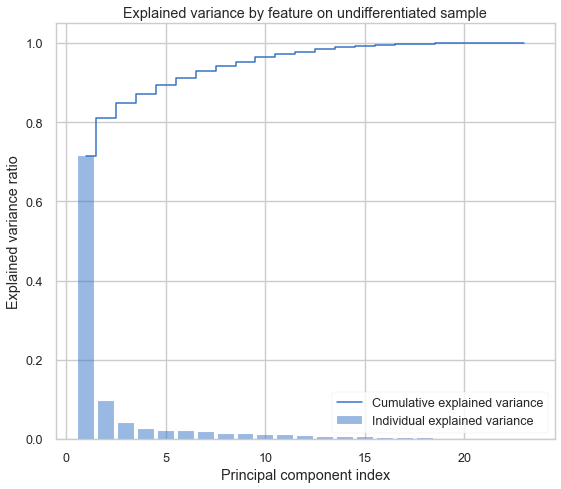

In [70]:
range_end = master_scaled_df0.shape[1] + 1

cov_mat = np.cov(master_scaled_df0.T)
eigen_vals, eigen_Vecs = np.linalg.eig(cov_mat)
# print('\nEigenvalues\n\n {}'.format(eigen_vals))

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

        # Here I'm plotting the variance for the first 20 features.  I already know it's going to be quite remarkable

plt.bar(range(1,range_end), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1,range_end), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc = 'best')
plt.title('Explained variance by feature on undifferentiated sample')
plt.tight_layout()
plt.show()

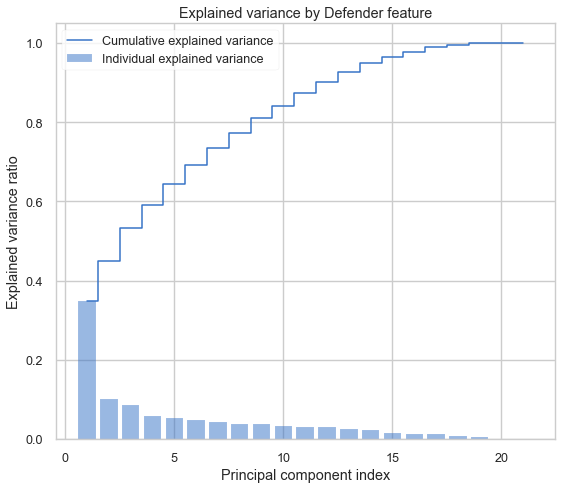

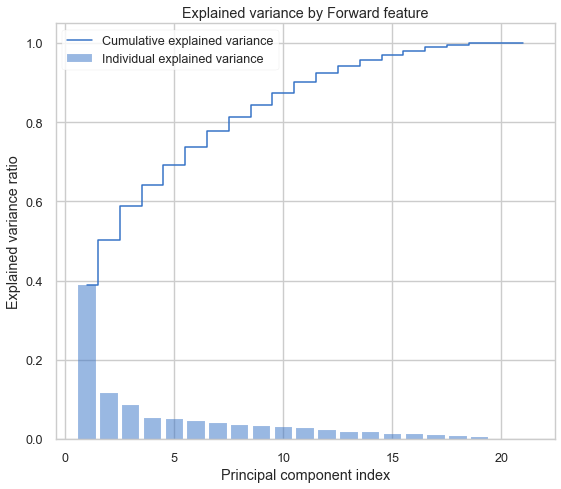

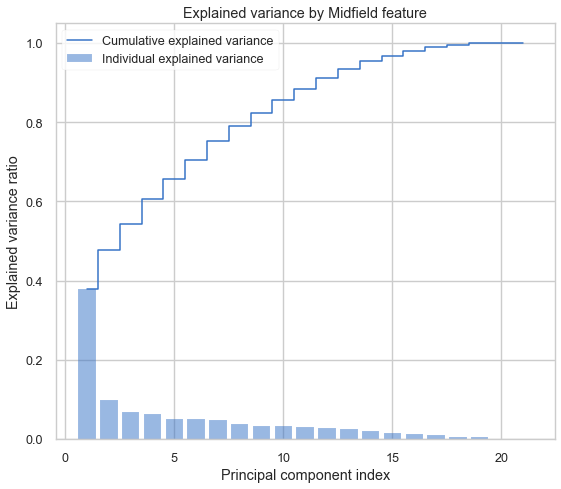

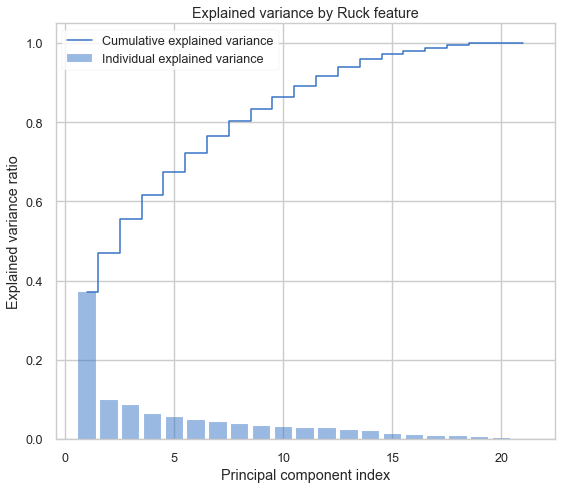

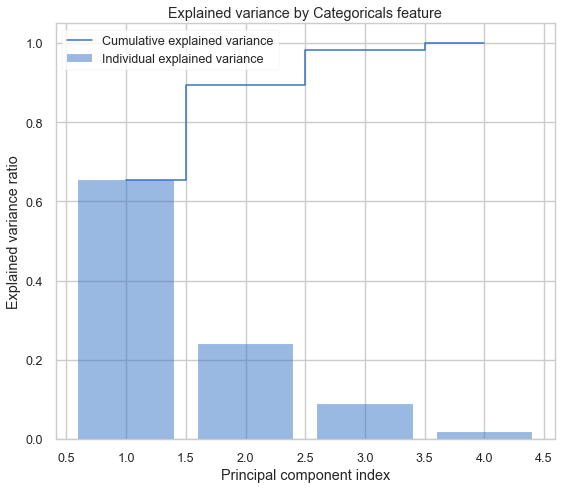

In [151]:
explained_variance(X1_train_scaled_df, X1_test_scaled_df)

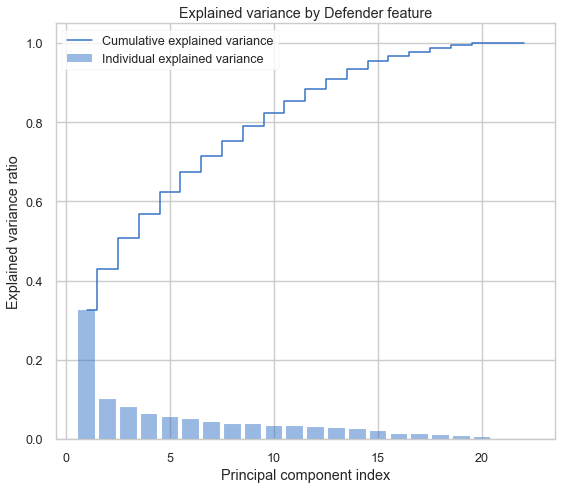

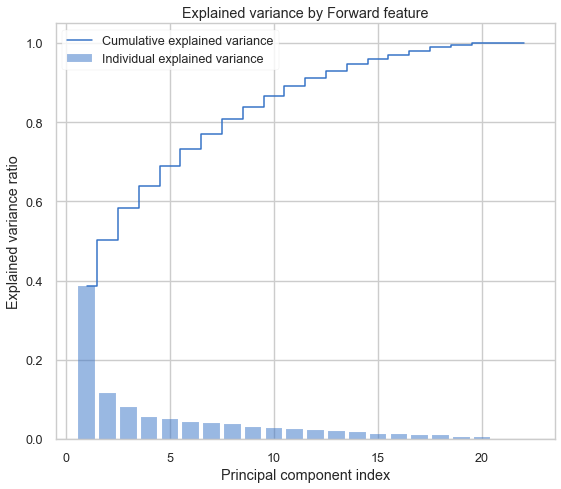

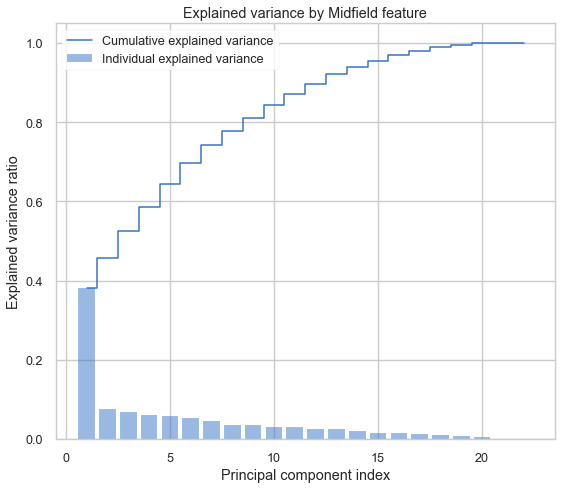

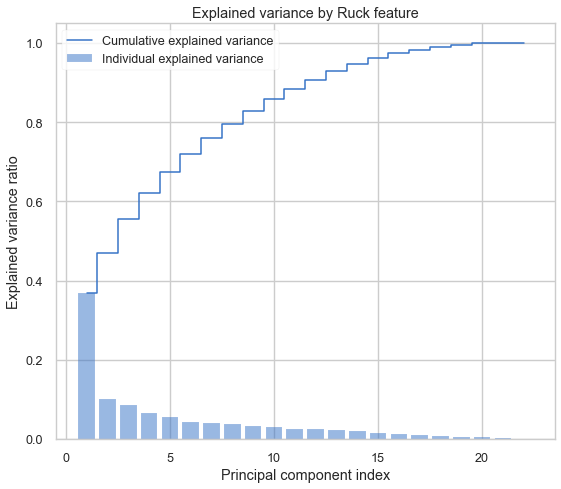

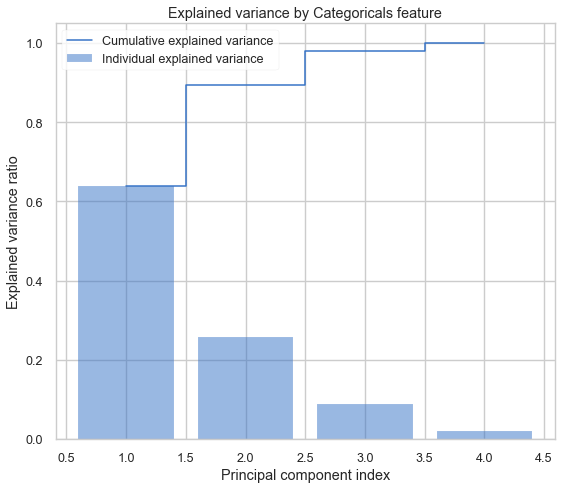

In [152]:
explained_variance(X2_train_scaled_df, X2_test_scaled_df)

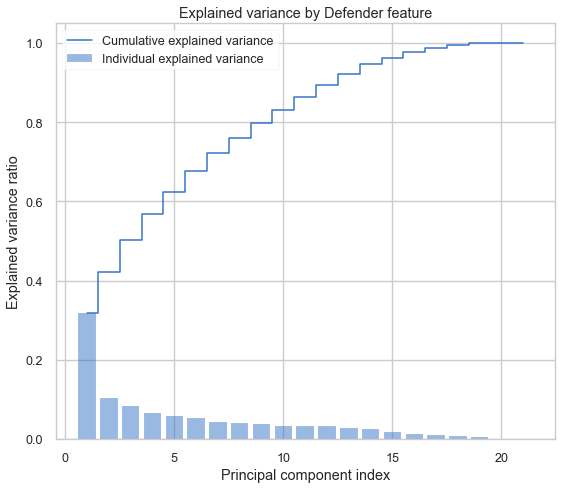

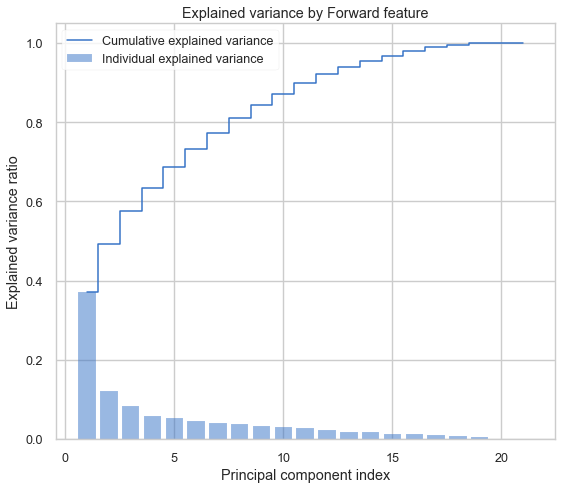

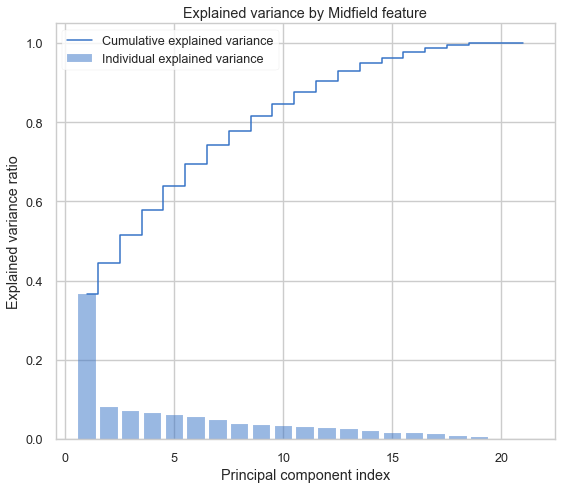

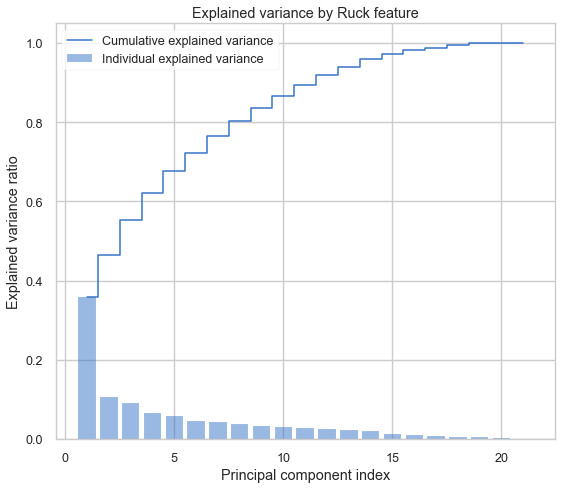

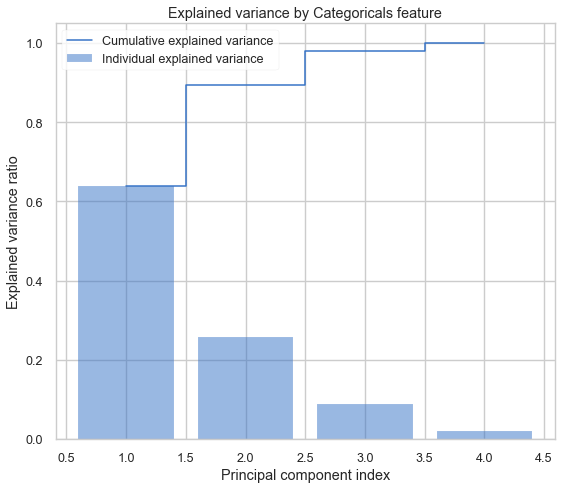

In [153]:
explained_variance(X3_train_scaled_df, X3_test_scaled_df)

# Baseline Machine Learning - Single Neuron Perceptrons

I begin the analysis here with single neuron perceptrons, using different classifiers.

In [71]:
# We will set a baseline with Naive Bayes, which makes no assumptions about the data.
# We'll start using all of the features.

# I can do this as a loop, I think

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

def naive_bayes(xtrain, ytrain, xtest, ytest):

    modelG = GaussianNB()
    modelG.fit(xtrain,ytrain);
    y_hat = modelG.predict(xtrain)
    baseline_training_accuracy = accuracy_score(ytrain, y_hat)
    print('The baseline training accuracy with Naive Bayes on the complete X1 sample is:', baseline_training_accuracy)


    y_hat2 = modelG.predict(xtest)
    baseline_test_accuracy = accuracy_score(ytest, y_hat2)
    print('The baseline accuracy on the test set with Naive Bayes on the complete X1 sample is:', baseline_test_accuracy)

In [72]:
naive_bayes(X0_train_scaled, y0_train, X0_test_scaled, y0_test)

The baseline training accuracy with Naive Bayes on the complete X1 sample is: 0.8152173913043478
The baseline accuracy on the test set with Naive Bayes on the complete X1 sample is: 0.7942028985507247


In [73]:
naive_bayes(X1_train_scaled, y1_train, X1_test_scaled, y1_test)

The baseline training accuracy with Naive Bayes on the complete X1 sample is: 0.7971014492753623
The baseline accuracy on the test set with Naive Bayes on the complete X1 sample is: 0.7594202898550725


In [74]:
naive_bayes(X2_train_scaled, y2_train, X2_test_scaled, y2_test)

The baseline training accuracy with Naive Bayes on the complete X1 sample is: 0.8224917309812569
The baseline accuracy on the test set with Naive Bayes on the complete X1 sample is: 0.8237885462555066


In [75]:
naive_bayes(X3_train_scaled, y3_train, X3_test_scaled, y3_test)

The baseline training accuracy with Naive Bayes on the complete X1 sample is: 0.8191841234840133
The baseline accuracy on the test set with Naive Bayes on the complete X1 sample is: 0.8281938325991189


In [60]:
# What I'd say here is that the shorter sample is actually a little bit more accurate, but the AMG stats don't make
# that big of a difference and I would think that they should.

Here I try a Logistic Regression classifier.

First, I do a gridsearch CV to pick the best hyperparameters.

When I apply the Logistic Regression classifier to the samples, using a stratified K-fold technique to improve the accuracy.  Much of the predictive power is based on what goes into the training set - the quality (and predictive power of the training data) varies pretty substantially.  Depending on the sample I can get between 50-60% accuracy and 80-90% accuracy.

In [76]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

def log_grid_graph(xtrain, ytrain, xtest, ytest):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(X1_train_scaled, y1_train)
#     print('Best parameters for original reduction')
#     print(gs.best_score_)
#     print(gs.best_params_)

    pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    ## Let's try a ROC / AUC graph
    
    cv = list(kfold)
    
    fig = plt.figure(figsize = (7, 5))
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    app_tpr = []
    
    for i, (train, test) in enumerate(cv):
        probas = pipe_lr.fit(xtrain[train], ytrain[train]).predict_proba(xtrain[test])
        fpr, tpr, thresholds = roc_curve(ytrain[test], probas[:, 1], pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'Random Guessing')
    
    mean_tpr/= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)'%mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'Perfect Performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
#     plt.legend(loc = 'lower right')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()


In [77]:
def log_grid_pipeline(xtrain, ytrain, xtest, ytest):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(X1_train_scaled, y1_train)
    print('Best parameters for original reduction')
    print(gs.best_score_)
    print(gs.best_params_)

    pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    scores_test = []
    scores_train = []

    for k, (train, test) in enumerate(kfold):
        pipe_lr.fit(xtrain[train], ytrain[train])
        score_train = pipe_lr.score(xtrain[train], ytrain[train])
        score_test = pipe_lr.score(xtrain[test], ytrain[test])
        scores_test.append(score_test)
        scores_train.append(score_train)
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))

    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(scores_train), np.std(scores_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(scores_test), np.std(scores_test)))


In [78]:
log_grid_pipeline(X0_train_scaled, y0_train, X0_test_scaled, y0_test)

Best parameters for original reduction
0.877536231884058
{'C': 2.7825594022071245, 'penalty': 'l1'}
Fold:  1, Class dist.: [542 700], Train Acc.: 0.881, Test Acc.: 0.899
Fold:  2, Class dist.: [542 700], Train Acc.: 0.888, Test Acc.: 0.870
Fold:  3, Class dist.: [542 700], Train Acc.: 0.885, Test Acc.: 0.862
Fold:  4, Class dist.: [542 700], Train Acc.: 0.890, Test Acc.: 0.848
Fold:  5, Class dist.: [542 700], Train Acc.: 0.886, Test Acc.: 0.862
Fold:  6, Class dist.: [542 700], Train Acc.: 0.878, Test Acc.: 0.891
Fold:  7, Class dist.: [542 700], Train Acc.: 0.887, Test Acc.: 0.877
Fold:  8, Class dist.: [542 700], Train Acc.: 0.886, Test Acc.: 0.877
Fold:  9, Class dist.: [541 701], Train Acc.: 0.884, Test Acc.: 0.877
Fold: 10, Class dist.: [541 701], Train Acc.: 0.884, Test Acc.: 0.862

CV Train accuracy: 0.885 +/-0.003
CV Test accuracy: 0.872 +/-0.014


In [186]:
log_grid_pipeline(X1_train_scaled, y1_train, X1_test_scaled, y1_test)

Best parameters for original reduction
0.877536231884058
{'C': 2.7825594022071245, 'penalty': 'l1'}
Fold:  1, Class dist.: [542 700], Train Acc.: 0.918, Test Acc.: 0.906
Fold:  2, Class dist.: [542 700], Train Acc.: 0.915, Test Acc.: 0.891
Fold:  3, Class dist.: [542 700], Train Acc.: 0.921, Test Acc.: 0.855
Fold:  4, Class dist.: [542 700], Train Acc.: 0.925, Test Acc.: 0.877
Fold:  5, Class dist.: [542 700], Train Acc.: 0.919, Test Acc.: 0.855
Fold:  6, Class dist.: [542 700], Train Acc.: 0.917, Test Acc.: 0.891
Fold:  7, Class dist.: [542 700], Train Acc.: 0.920, Test Acc.: 0.891
Fold:  8, Class dist.: [542 700], Train Acc.: 0.924, Test Acc.: 0.848
Fold:  9, Class dist.: [541 701], Train Acc.: 0.918, Test Acc.: 0.870
Fold: 10, Class dist.: [541 701], Train Acc.: 0.914, Test Acc.: 0.891

CV Train accuracy: 0.919 +/-0.003
CV Test accuracy: 0.878 +/-0.019


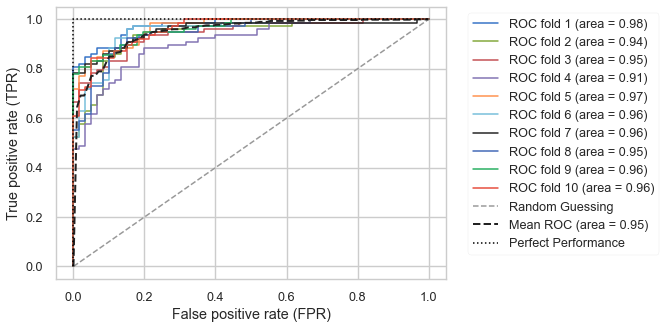

In [79]:
log_grid_graph(X0_train_scaled, y0_train, X0_test_scaled, y0_test)

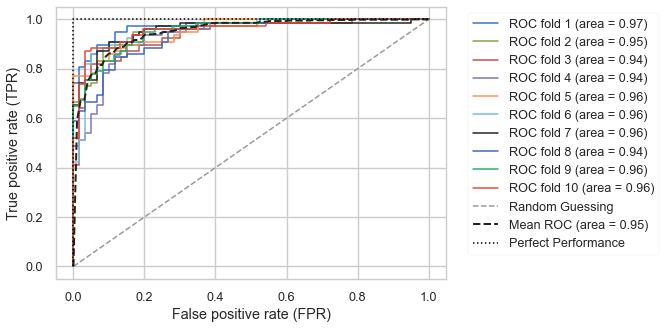

In [189]:
log_grid_graph(X1_train_scaled, y1_train, X1_test_scaled, y1_test)

In [80]:
log_grid_pipeline(X2_train_scaled, y2_train, X2_test_scaled, y2_test)

Best parameters for original reduction
0.877536231884058
{'C': 2.7825594022071245, 'penalty': 'l1'}
Fold:  1, Class dist.: [353 463], Train Acc.: 0.947, Test Acc.: 0.868
Fold:  2, Class dist.: [353 463], Train Acc.: 0.942, Test Acc.: 0.956
Fold:  3, Class dist.: [353 463], Train Acc.: 0.944, Test Acc.: 0.901
Fold:  4, Class dist.: [353 463], Train Acc.: 0.947, Test Acc.: 0.857
Fold:  5, Class dist.: [353 463], Train Acc.: 0.947, Test Acc.: 0.901
Fold:  6, Class dist.: [352 464], Train Acc.: 0.947, Test Acc.: 0.901
Fold:  7, Class dist.: [352 464], Train Acc.: 0.949, Test Acc.: 0.890
Fold:  8, Class dist.: [353 464], Train Acc.: 0.941, Test Acc.: 0.900
Fold:  9, Class dist.: [353 464], Train Acc.: 0.941, Test Acc.: 0.911
Fold: 10, Class dist.: [353 464], Train Acc.: 0.940, Test Acc.: 0.900

CV Train accuracy: 0.945 +/-0.003
CV Test accuracy: 0.899 +/-0.025


In [81]:
log_grid_pipeline(X3_train_scaled, y3_train, X3_test_scaled, y3_test)

Best parameters for original reduction
0.877536231884058
{'C': 2.7825594022071245, 'penalty': 'l1'}
Fold:  1, Class dist.: [353 463], Train Acc.: 0.942, Test Acc.: 0.857
Fold:  2, Class dist.: [353 463], Train Acc.: 0.934, Test Acc.: 0.923
Fold:  3, Class dist.: [353 463], Train Acc.: 0.933, Test Acc.: 0.923
Fold:  4, Class dist.: [353 463], Train Acc.: 0.934, Test Acc.: 0.879
Fold:  5, Class dist.: [353 463], Train Acc.: 0.939, Test Acc.: 0.923
Fold:  6, Class dist.: [352 464], Train Acc.: 0.936, Test Acc.: 0.901
Fold:  7, Class dist.: [352 464], Train Acc.: 0.939, Test Acc.: 0.868
Fold:  8, Class dist.: [353 464], Train Acc.: 0.931, Test Acc.: 0.911
Fold:  9, Class dist.: [353 464], Train Acc.: 0.934, Test Acc.: 0.911
Fold: 10, Class dist.: [353 464], Train Acc.: 0.934, Test Acc.: 0.900

CV Train accuracy: 0.936 +/-0.003
CV Test accuracy: 0.900 +/-0.023


Some observations:

We're talking about marginal gains.  The POSGRU analysis adds about 3% accuracy in this logistic regression.  AMG doesn't really appear to add much value when comparing samples 2 and 3.  Is this significant?

Here, I follow the same process, but with a Support Vector Model classifier.

This overtrains a little bit, but I think I can control it with some lasso controls.  But honestly, I'm not terribly concerned with this much variability right now.  I'm looking for a performance baseline.

In [82]:
def svc_grid_pipeline(xtrain, ytrain, xtest, ytest):
    
    pipe_svc = make_pipeline(SVC(random_state = 0))

    param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                 {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

    
    gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(xtrain, ytrain)
    print(gs.best_score_)
    print(gs.best_params_)
    
    pipe_svc = make_pipeline(SVC(kernel = gs.best_params_['svc__kernel'],C = gs.best_params_['svc__C'], random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    scores_test = []
    scores_train = []

    for k, (train, test) in enumerate(kfold):
        pipe_svc.fit(xtrain[train], ytrain[train])
        score_train = pipe_svc.score(xtrain[train], ytrain[train])
        score_test = pipe_svc.score(xtrain[test], ytrain[test])
        scores_test.append(score_test)
        scores_train.append(score_train)
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))

    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(scores_train), np.std(scores_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(scores_test), np.std(scores_test)))


In [83]:
svc_grid_pipeline(X0_train_scaled, y0_train, X0_test_scaled, y0_test)

0.8731884057971016
{'svc__C': 100.0, 'svc__kernel': 'linear'}
Fold:  1, Class dist.: [542 700], Train Acc.: 0.883, Test Acc.: 0.899
Fold:  2, Class dist.: [542 700], Train Acc.: 0.887, Test Acc.: 0.877
Fold:  3, Class dist.: [542 700], Train Acc.: 0.889, Test Acc.: 0.870
Fold:  4, Class dist.: [542 700], Train Acc.: 0.892, Test Acc.: 0.812
Fold:  5, Class dist.: [542 700], Train Acc.: 0.886, Test Acc.: 0.870
Fold:  6, Class dist.: [542 700], Train Acc.: 0.882, Test Acc.: 0.899
Fold:  7, Class dist.: [542 700], Train Acc.: 0.890, Test Acc.: 0.884
Fold:  8, Class dist.: [542 700], Train Acc.: 0.890, Test Acc.: 0.877
Fold:  9, Class dist.: [541 701], Train Acc.: 0.885, Test Acc.: 0.884
Fold: 10, Class dist.: [541 701], Train Acc.: 0.888, Test Acc.: 0.862

CV Train accuracy: 0.887 +/-0.003
CV Test accuracy: 0.873 +/-0.023


In [ ]:
svc_grid_pipeline(X1_train_scaled, y1_train, X1_test_scaled, y1_test)

In [170]:
svc_grid_pipeline(X2_train_scaled, y2_train, X2_test_scaled, y2_test)

0.8886935286935287
{'svc__C': 1.0, 'svc__kernel': 'linear'}
Fold:  1, Class dist.: [353 463], Train Acc.: 0.950, Test Acc.: 0.846
Fold:  2, Class dist.: [353 463], Train Acc.: 0.944, Test Acc.: 0.912
Fold:  3, Class dist.: [353 463], Train Acc.: 0.941, Test Acc.: 0.912
Fold:  4, Class dist.: [353 463], Train Acc.: 0.945, Test Acc.: 0.868
Fold:  5, Class dist.: [353 463], Train Acc.: 0.957, Test Acc.: 0.868
Fold:  6, Class dist.: [352 464], Train Acc.: 0.947, Test Acc.: 0.879
Fold:  7, Class dist.: [352 464], Train Acc.: 0.950, Test Acc.: 0.890
Fold:  8, Class dist.: [353 464], Train Acc.: 0.942, Test Acc.: 0.911
Fold:  9, Class dist.: [353 464], Train Acc.: 0.938, Test Acc.: 0.911
Fold: 10, Class dist.: [353 464], Train Acc.: 0.942, Test Acc.: 0.889

CV Train accuracy: 0.946 +/-0.005
CV Test accuracy: 0.889 +/-0.022


In [171]:
svc_grid_pipeline(X3_train_scaled, y3_train, X3_test_scaled, y3_test)

0.8931013431013431
{'svc__C': 10.0, 'svc__kernel': 'linear'}
Fold:  1, Class dist.: [353 463], Train Acc.: 0.946, Test Acc.: 0.868
Fold:  2, Class dist.: [353 463], Train Acc.: 0.941, Test Acc.: 0.901
Fold:  3, Class dist.: [353 463], Train Acc.: 0.946, Test Acc.: 0.923
Fold:  4, Class dist.: [353 463], Train Acc.: 0.944, Test Acc.: 0.890
Fold:  5, Class dist.: [353 463], Train Acc.: 0.941, Test Acc.: 0.890
Fold:  6, Class dist.: [352 464], Train Acc.: 0.942, Test Acc.: 0.890
Fold:  7, Class dist.: [352 464], Train Acc.: 0.944, Test Acc.: 0.846
Fold:  8, Class dist.: [353 464], Train Acc.: 0.942, Test Acc.: 0.911
Fold:  9, Class dist.: [353 464], Train Acc.: 0.949, Test Acc.: 0.933
Fold: 10, Class dist.: [353 464], Train Acc.: 0.944, Test Acc.: 0.878

CV Train accuracy: 0.944 +/-0.002
CV Test accuracy: 0.893 +/-0.024


I did a Random Forest / Decision Tree classifier just because Young, et.al. used one, but I was not enthusiastic about doing that because Random Forests are a bit of a "black box" - even blacker than the rest of machine learning, which is pretty opaque!

I gave it the same very reduced dataset that I fed the other classifiers, so that may be why it came up so short.  I was expecting a very long tree. But regardless, this was the worst performing model.

In [65]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                 param_grid = [{'max_depth': [1,2,3,4,5,6,7,None]}],
                 scoring = 'accuracy',
                 cv = 10)

gs = gs.fit(X_train_scaled, y_train)

print(gs.best_score_)
print(gs.best_params_)

train_scores = cross_val_score(gs, X_train_scaled, y_train, scoring = 'accuracy', cv = 15)
test_scores = cross_val_score(gs, X_test_scaled, y_test, scoring = 'accuracy', cv = 15)

print('CV accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(train_scores), np.std(train_scores)))
print('CV accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(test_scores), np.std(test_scores)))

0.7195652173913043
{'max_depth': 3}
CV accuracy with Decision Tree classifier: 0.732 +/- 0.037
CV accuracy with Decision Tree classifier: 0.742 +/- 0.072


It all depends on the train test split, really.  One split performs at a 90+% rate.  Another split performs at a 50-60% accuracy rate.

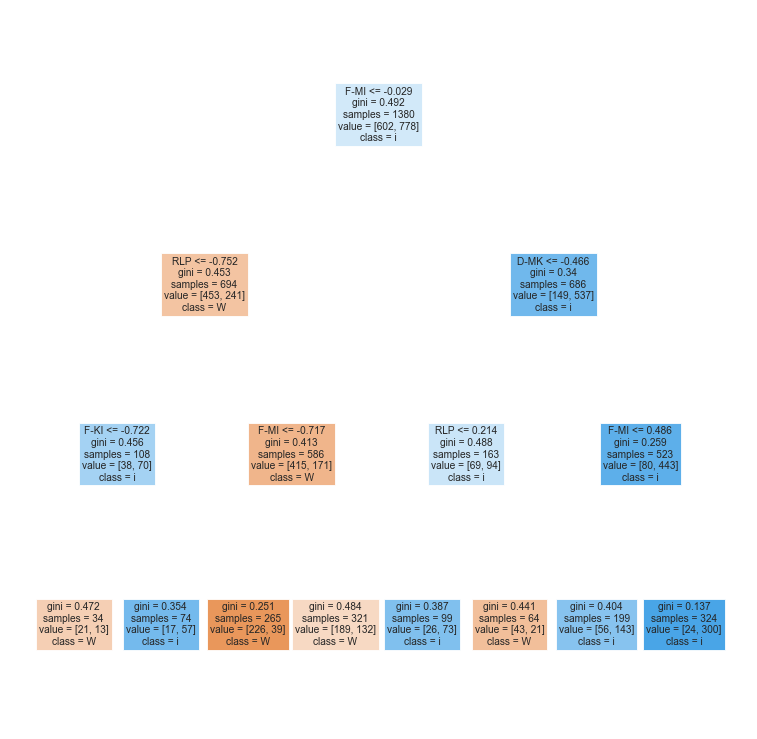

In [86]:
from sklearn import tree

clf = DecisionTreeClassifier(max_depth = 3)

clf.fit(X_train_scaled, y_train)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)

tree.plot_tree(clf, feature_names = cn, class_names = 'Winner', filled = True);

fig.savefig('baseline_decision_tree.png')

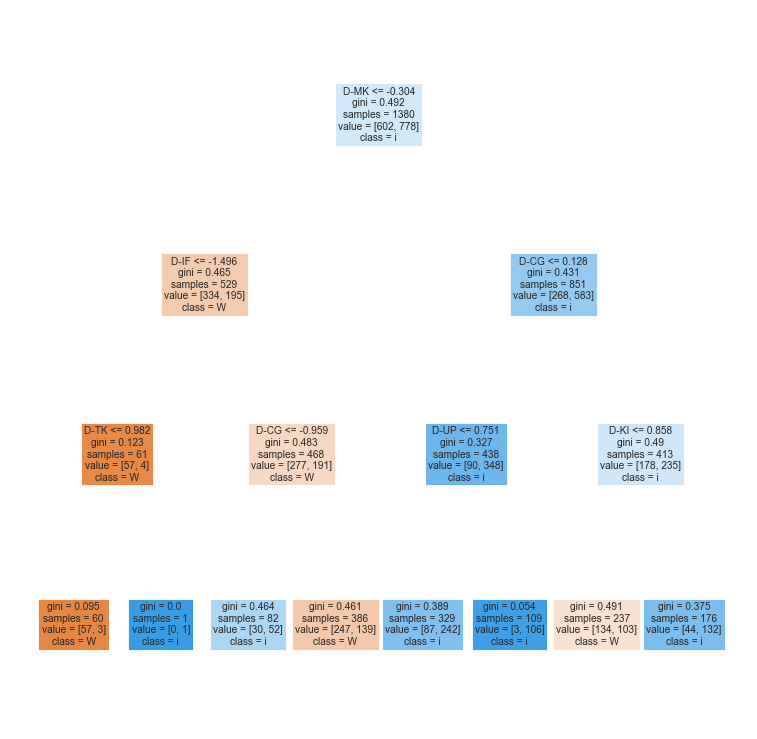

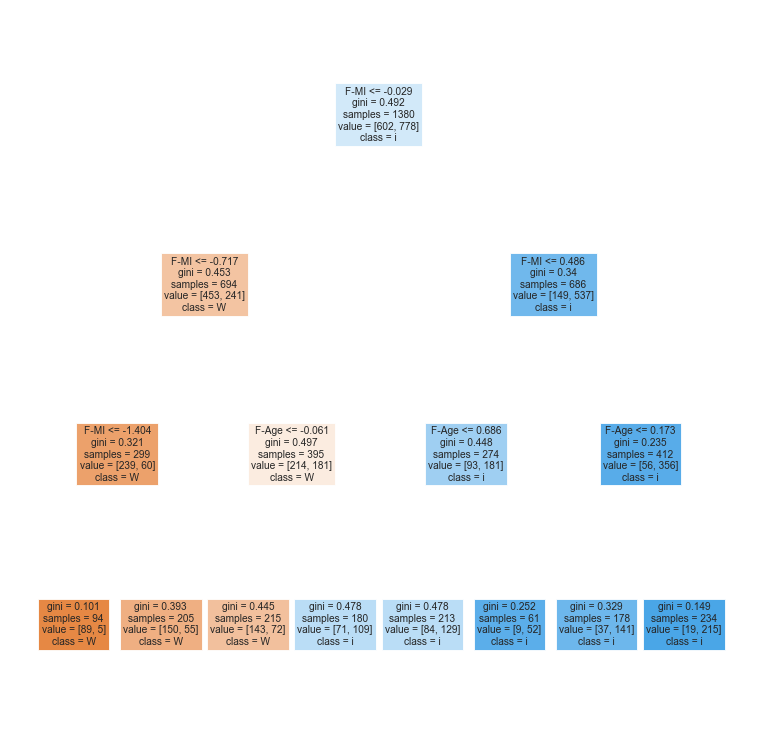

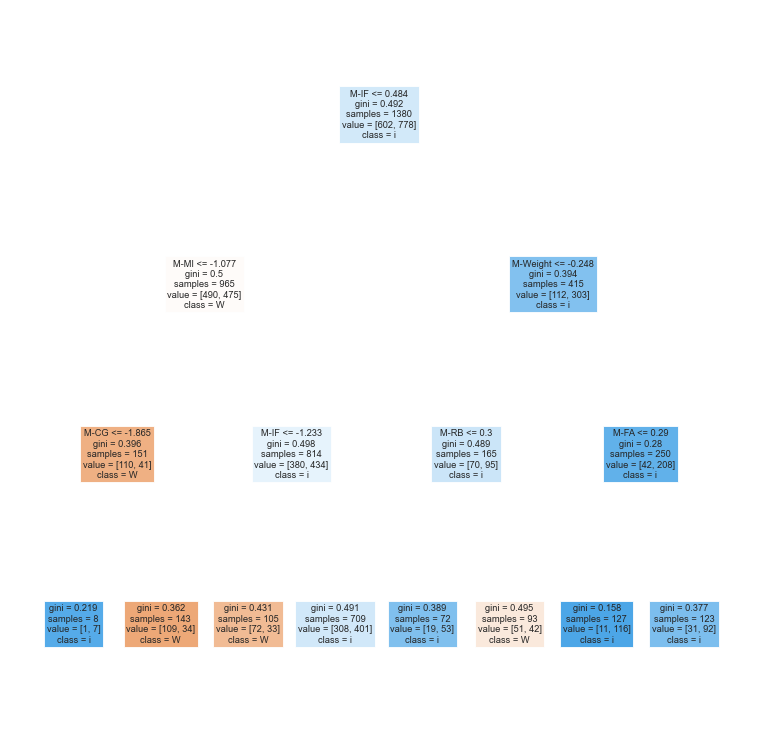

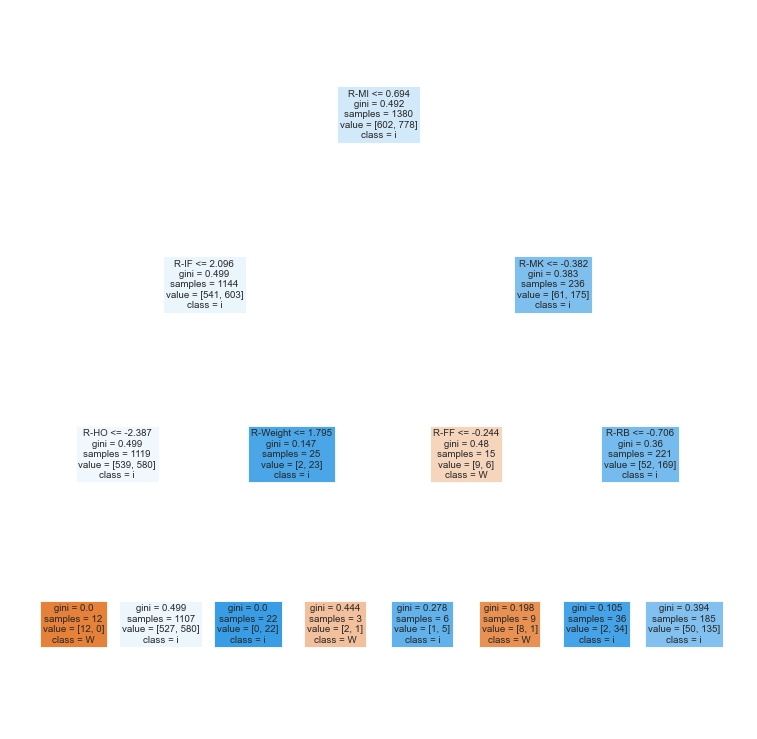

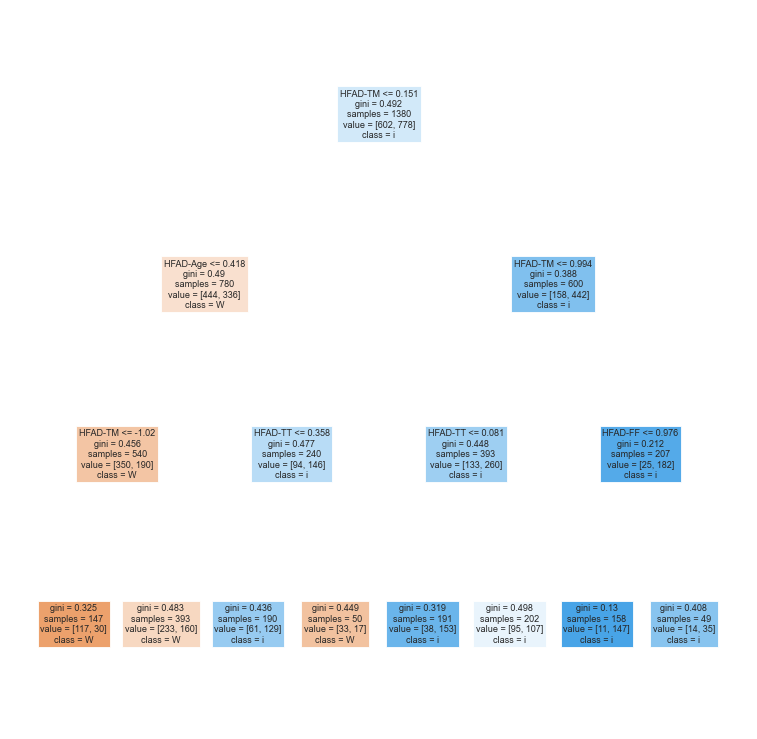

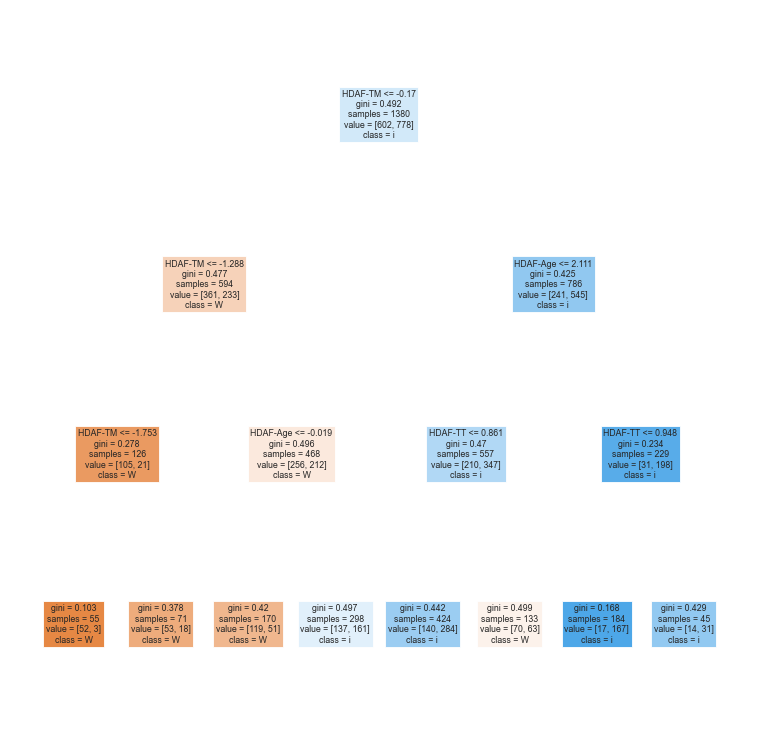

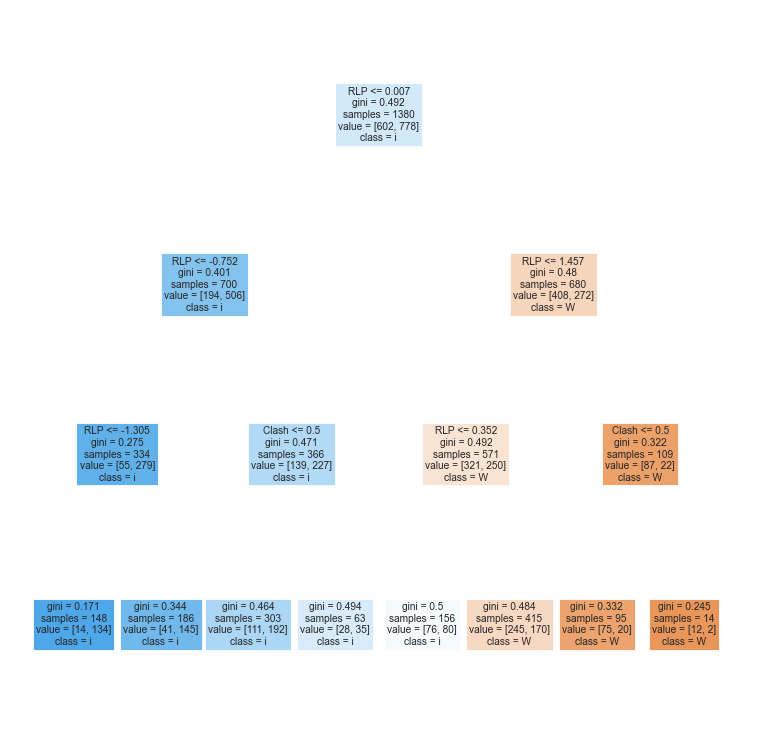

In [144]:
# I want to add HDAF and HFAD groups in here as well.  Have to do that further up
# I really don't understand what this is telling me. I have to review this.

pos_groups = [D_train_scaled, F_train_scaled, M_train_scaled, R_train_scaled, HFAD_train_scaled, HDAF_train_scaled, C_train_subset]

for pg in pos_groups:
    
    clf.fit(pg, y_train)
    
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
    cn = pg.columns.to_list()
    tree.plot_tree(clf, feature_names = cn, class_names = 'Winner', filled = True);
    

#     fig.savefig('Defense_decision_tree.png')

# Multilayer Perceptron

In my early frustration with TensorFlow I wanted to establish a baseline with the single layer NeuralNet MLP that we had built in class.  There is no back propagation in this model.

In [190]:
from urllib.request import urlretrieve

url = 'https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/neuralnet.py'
urlretrieve(url, 'neuralnet.py')

from neuralnet import NeuralNetMLP

Here, the hyperparameters are very clear and visible.  We can't do a grid search with this classifier, so I manipulated these hyperparameters a little bit manually, trying, unsuccessfully, to reduce loss.

I did create a validation subset inside of the training data.

In [191]:
nn = NeuralNetMLP(n_hidden = 10,
                 l2 = 0.01,
                 epochs = 200,
                 eta = 0.002,
                 minibatch_size = 50,
                 shuffle = True,
                 seed = 1)

In [193]:
# nn.fit(X_train = X_train_scaled[:1013], y_train = y_train[:1013],
#       X_valid = X_train_scaled[1013:], y_valid = y_train[1013:])

nn.fit(X_train = X1_train_scaled, y_train = y1_train,
      X_valid = X1_test_scaled, y_valid = y1_test)

200/200 | Cost: 194.88 | Train/Valid Acc.: 98.91%/85.51%  

In [196]:
nn.fit(X_train = X2_train_scaled, y_train = y2_train,
      X_valid = X2_test_scaled, y_valid = y2_test)

200/200 | Cost: 106.30 | Train/Valid Acc.: 99.56%/83.26%  

In [197]:
nn.fit(X_train = X3_train_scaled, y_train = y3_train,
      X_valid = X3_test_scaled, y_valid = y3_test)

200/200 | Cost: 101.38 | Train/Valid Acc.: 99.45%/85.90%  

In [ ]:
# I am SERIOUSLY, SERIOUSLY, SERIOUSLY overtraining on the training data

We definitely find a steady minimum for cost, but it seems so very high.

The class does not have a way to report on validation cost that I can see in the code.

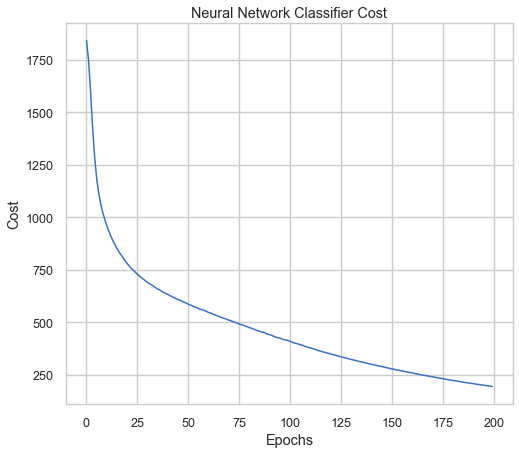

In [194]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Neural Network Classifier Cost')
plt.show()

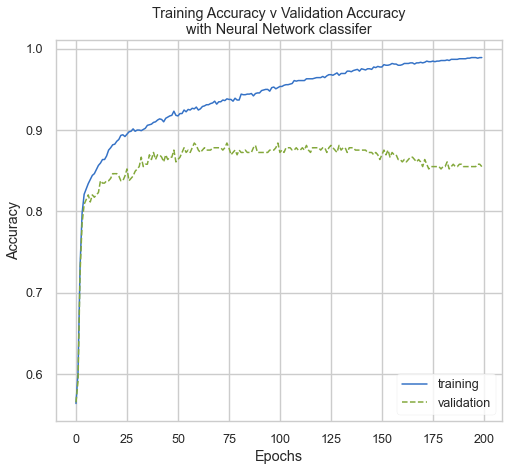

In [195]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label = 'training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label = 'validation', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training Accuracy v Validation Accuracy\nwith Neural Network classifer')
plt.legend(loc = 'lower right')
plt.show()

OK, so observations here with the NN we built in class.  

This does exactly the same, about 86% on the validation set, and the cost is fairly low.  Again, validation probably needs to be reset to be the x_test set; it's just nomenclature. I don't have a separate test, just validation.

I am definitely getting better, but it's not perfect.  I'm still treating the dataframe as one big thing.

I'm definitely overtraining!

# TensorFlow setup

Everything that I've done so far was on my initial, "regular dataset".  I cut it up and put it back together, a bunch of times, but at least I have everything normalized the way I want with the  fit.

But, let's scrap that and start fresh with TensorFlow on my smallest dataframe possible, whatever we wind up with.

Essentially, I am using a TensorFlow tutorial (https://www.tensorflow.org/tutorials/keras/regression) to start fresh with a new, un-normalized dataframe.  In these next few cells I am following that TensorFlow example to work through the TensorFlow neural network model.  Of course, I have a classification problem, not a regression problem, so the tutorial was mostly useful in the setup process.

In [110]:

tf_df = copy.deepcopy(home_away_net_complete)

# tf_df[['Home', 'Away', 'Season', 'Winner']] = home_away_net_complete[['Home', 'Away', 'Season', 'Winner']]


# col = tf_df.pop('Season')
# tf_df.insert(0, col.name, col)
# col = tf_df.pop('Away')
# tf_df.insert(0, col.name, col)
# col = tf_df.pop('Home')
# tf_df.insert(0, col.name, col)

tf_df

,Home,Away,Season,Game,Round,D-DI,D-KI,D-MK,D-HB,D-GL,...,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,RLP,Net Score,Winner
0,GWS,Sydney,2012,Game1,round1,-31.0,-28.0,-18.0,-3.0,-2.0,...,-4.0,0.208333,-1.666667,-1.916667,0,1,1,11,-63,Away
1,Richmond,Carlton,2012,Game2,round1,-44.0,-37.0,-20.0,-7.0,-3.0,...,-11.0,1.833333,1.333333,-2.500000,0,0,0,7,-44,Away
2,Hawthorn,Collingwood,2012,Game3,round1,38.0,15.0,12.0,23.0,2.0,...,17.0,-1.000000,-7.583333,2.708333,0,1,1,2,22,Home
3,Melbourne,Brisbane,2012,Game4,round1,-36.0,-13.0,-25.0,-23.0,-1.0,...,17.0,5.000000,2.472222,-1.583333,1,0,0,-2,-41,Away
4,Gold Coast,Adelaide,2012,Game5,round1,-225.0,-132.0,-70.0,-93.0,-4.0,...,-34.0,7.517857,3.089286,-1.535714,1,0,0,3,-69,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,North Melbourne,Adelaide,2020,Game5,round9,37.0,40.0,23.0,1.0,3.0,...,5.0,4.232143,6.375000,4.553571,1,1,0,-1,69,Home
1732,St. Kilda,Sydney,2020,Game6,round9,43.0,33.0,37.0,8.0,3.0,...,16.0,4.208333,3.527778,0.722222,1,1,0,-10,53,Home
1733,West Coast,Geelong,2020,Game7,round9,-69.0,-55.0,-33.0,-14.0,-2.0,...,-23.0,2.250000,-5.375000,-0.750000,1,0,0,2,9,Home
1734,Gold Coast,GWS,2020,Game8,round9,-109.0,-86.0,-52.0,-23.0,0.0,...,-4.0,2.500000,1.000000,1.333333,1,0,0,-2,-26,Away


In [111]:
y = tf_df['Winner']
le = LabelEncoder()
y = le.fit_transform(y)

le.transform(['Home', 'Away'])

array([1, 0], dtype=int64)

In [112]:
tf_df['Encoded Winner'] = y

In [119]:
tf_train = tf_df.sample(frac = 0.8, random_state = 1)
tf_test = tf_df.drop(tf_train.index)

tf_train.drop(columns = ['Home', 'Away', 'Season', 'Game', 'Round', 'Winner'], inplace = True)
tf_test.drop(columns = ['Home', 'Away', 'Season', 'Game', 'Round', 'Winner'], inplace = True)

tf_train_labels = tf_train.pop('Encoded Winner')
tf_test_labels = tf_test.pop('Encoded Winner')

# tf_train.iloc[:,:-5]

tf_train_stats = tf_train.describe()
tf_train_stats = tf_train_stats.transpose()

In [159]:
# Categoricals don't need to be normalized
# Why don't I just used this instead of trying to redo it?

X_train_scaled_df

,RLP,D-DI,D-KI,D-MK,D-HB,D-HO,D-TK,D-RB,D-IF,D-CL,...,HDAF-TP,HDAF-FF,HDAF-TT,HDAF-Height,HDAF-Weight,HDAF-Age,Intrastate,Same / Neutral Venue,Clash,Winner
0,-0.269072,0.058828,-0.215463,-0.115506,0.398938,0.014892,-0.391907,0.501472,0.438971,-0.012915,...,-0.432109,0.446841,-0.844209,-1.212736,-1.620014,1.910714,0.0,1.0,1.0,1
1,-0.269072,0.722677,1.454021,1.717898,-0.391618,0.014892,1.787718,-0.366007,0.087182,-0.194781,...,1.195016,-0.057981,0.292555,0.515650,0.617339,2.069444,1.0,0.0,0.0,1
2,-1.373776,0.808335,1.113310,1.663974,0.223259,-0.588945,-1.150037,-0.908182,0.790760,-0.012915,...,1.380385,3.223363,-0.319549,-0.615117,-0.378615,-2.458333,0.0,1.0,1.0,1
3,1.111809,0.637019,0.636315,1.394356,0.486777,0.014892,-0.486673,1.260517,0.087182,-0.558513,...,-0.184951,-0.815215,-0.669323,-0.090661,0.681960,-0.269841,0.0,1.0,1.0,1
4,0.973721,-1.268871,-1.033169,-1.140055,-1.313932,0.014892,-1.718635,0.718342,-2.140814,-1.831575,...,-1.564917,0.446841,-0.494436,-0.809253,-0.048142,1.238095,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0.973721,-0.626436,-1.033169,-0.978284,0.047580,-0.387666,-1.244804,-0.257572,0.204445,0.168951,...,-0.102565,-1.320037,1.254433,0.417134,1.287921,3.642857,0.0,1.0,1.0,0
1376,-0.130984,1.215211,1.215524,0.100189,0.925975,0.014892,1.313887,-0.474442,1.611601,1.623879,...,-0.267337,0.951663,-0.232105,-1.129287,-0.040546,1.550000,0.0,1.0,1.0,1
1377,-0.683336,-0.198146,-0.283605,-0.816513,-0.040260,-2.601734,-0.012842,-0.908182,0.087182,0.350817,...,-0.967618,0.951663,-1.718644,0.262839,0.137785,0.555556,0.0,0.0,0.0,0
1378,-0.130984,-0.476535,-0.317676,-0.331201,-0.567297,0.014892,-0.676206,0.176167,-0.147343,1.987611,...,-1.853269,-1.067626,-0.232105,0.238500,-0.219103,1.057143,1.0,0.0,0.0,0


In [121]:
def norm(x):
    return (x - tf_train_stats['mean']) / tf_train_stats['std']

normed_train_data = norm(tf_train)
normed_test_data = norm(tf_test)

In [122]:
# Just checking to see that the number of home wins vs. away wins is approximately the same in the two datasets.
# It only differs by about .9%

unique_train, counts_train = np.unique(tf_train_labels, return_counts = True)
train_ratio = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(tf_test_labels, return_counts = True)
test_ratio = dict(zip(unique_test, counts_test))

percent_home_win_train = train_ratio[1] / (train_ratio[0] + train_ratio[1]) * 100
percent_home_win_test = test_ratio[1] / (test_ratio[0] + test_ratio[1]) * 100

print(percent_home_win_train, percent_home_win_test)

56.086956521739125 57.68115942028985


# The TensorFlow model

Tuning the TensorFlow model was arduous.  A machine that is nothing but pivot points can't do any work: something has to remain fixed to anchor the machine.  So, for me, working with TensorFlow was daunting.

Actually, the tedious dimensionality reduction process was born from my first attempt at putting the entire dataframe into TensorFlow, hoping that it would work "magic" and produce an awesome result, but it didn't.

So, I built a simple model, and then used grid search to tune the model for the best possible performance.  The main gridsearch is shown in the next section.  It took about a 1/2 day to run, so I wouldn't recommend it (I have it commented out), but this model is the result of the hyperparameter tuning that I did.

In [67]:
# So at this point, I've just recreated my data following the example from the tensorflow page.

In [123]:
tf_train.keys()

Index(['D-DI', 'D-KI', 'D-MK', 'D-HB', 'D-GL', 'D-BH', 'D-HO', 'D-TK', 'D-RB',
       'D-IF',
       ...
       'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age',
       'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score'],
      dtype='object', length=119)

In [124]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(5, activation = 'tanh', input_shape = [len(tf_train.keys())]),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(10, activation = 'tanh'),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(5, activation = 'tanh'),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(lr = .002)
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [125]:
model = build_model()

In [126]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 600       
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 721
Trainable params: 721
Non-trainable params: 0
__________________________________________________________

In [127]:
model.save('initial_model.h5')

In [128]:
EPOCHS = 400

history = model.fit(
  normed_train_data, tf_train_labels, batch_size = 35,    
  epochs=EPOCHS, validation_split = 0.2, shuffle = True, verbose=0)

In [129]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
395,0.103806,0.964674,0.657611,0.916667,395
396,0.082662,0.975543,0.651839,0.923913,396
397,0.102066,0.971014,0.649669,0.920290,397
398,0.117227,0.971014,0.648652,0.923913,398
399,0.098187,0.969203,0.653383,0.920290,399


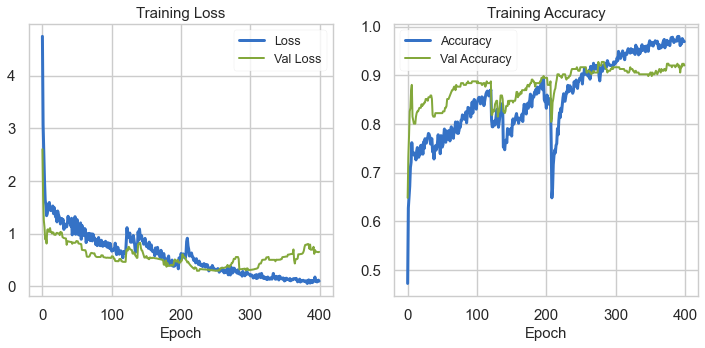

In [130]:
hist = history.history
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'], lw = 3, label = 'Loss')
ax.plot(hist['val_loss'], lw = 2, label = 'Val Loss')
ax.set_title('Training Loss', size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.legend(loc = 0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'], lw = 3, label = 'Accuracy')
ax.plot(hist['val_accuracy'], lw = 2, label = 'Val Accuracy')
ax.set_title('Training Accuracy', size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.legend(loc = 0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

In [131]:
results = model.evaluate(normed_test_data, tf_test_labels, verbose = 2)
print('Test loss: {:.4f} Test Acc: {:.4f}'.format(*results))

345/345 - 0s - loss: 0.2640 - accuracy: 0.9507
Test loss: 0.2640 Test Acc: 0.9507


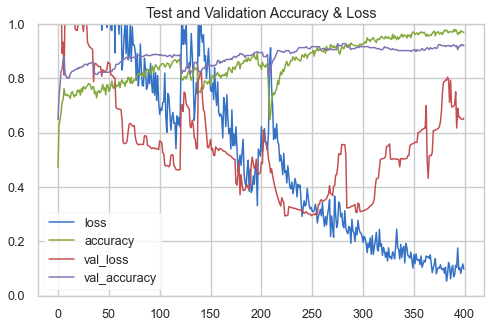

In [142]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Test and Validation Accuracy & Loss')
plt.show();

In [141]:
# I think this is telling me that I get stuck in some local depressions / local minima, but the TF model is able to
# work its way out of those "blind canyons" and perform fairly respectably.  Validation loss is high, which means it's 
# NOT working its way out of those local minima.  I think.

# New Section

What I want to do here now is to start working my TensorFlow model on the POSGRU subsets before knitting them together for one final run to make a prediction.

Let's start by looking at running this model on each POSGRU subset first.  Then we can take a look at how to take the outputs and knit them back together into a final prediction based on win / loss.

In [148]:
normed_train_data

D_tf_normed_train, D_tf_normed_test = [col for col in normed_train_data if col.startswith('D-')], [col for col in normed_test_data if col.startswith('D-')]
D_tf_normed_train, D_tf_normed_test = X_train_scaled_df[D_train_subset], X_test_scaled_df[D_test_subset]


F_tf_normed_train, F_tf_normed_test = [col for col in normed_train_data if col.startswith('F-')], [col for col in normed_test_data if col.startswith('F-')]
F_tf_normed_train, F_tf_normed_test = X_train_scaled_df[F_train_subset], X_test_scaled_df[F_test_subset]

M_tf_normed_train, M_tf_normed_test = [col for col in normed_train_data if col.startswith('M-')], [col for col in normed_test_data if col.startswith('M-')]
M_tf_normed_train, M_tf_normed_test = X_train_scaled_df[M_train_subset], X_test_scaled_df[M_test_subset]

R_tf_normed_train, R_tf_normed_test = [col for col in normed_train_data if col.startswith('R-')], [col for col in normed_test_data if col.startswith('R-')]
R_tf_normed_train, R_tf_normed_test = X_train_scaled_df[R_train_subset], X_test_scaled_df[R_test_subset]

HDAF_tf_normed_train, HDAF_tf_normed_test = [col for col in normed_train_data if col.startswith('HDAF-')], [col for col in normed_test_data if col.startswith('HDAF-')]
HDAF_tf_normed_train, HDAF_tf_normed_test = X_train_scaled_df[HDAF_train_subset], X_test_scaled_df[HDAF_test_subset]

HFAD_tf_normed_train, HFAD_tf_normed_test = [col for col in normed_train_data if col.startswith('HFAD-')], [col for col in normed_test_data if col.startswith('HFAD-')]
HFAD_tf_normed_train, HFAD_tf_normed_test = X_train_scaled_df[HFAD_train_subset], X_test_scaled_df[HFAD_test_subset]

C_tf_normed_train, C_tf_normed_test = normed_train_data[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']], normed_test_data[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']]

In [150]:
C_tf_normed_train

,Intrastate,Same / Neutral Venue,Clash,RLP
974,0.702246,-0.548126,-0.415147,-0.853447
611,-1.422971,1.823077,2.407037,1.462023
772,0.702246,-0.548126,-0.415147,1.053410
769,0.702246,-0.548126,-0.415147,-1.943080
595,0.702246,-0.548126,-0.415147,0.644798
...,...,...,...,...
70,-1.422971,-0.548126,-0.415147,0.236186
613,0.702246,-0.548126,-0.415147,2.279247
1182,0.702246,-0.548126,-0.415147,2.279247
1664,0.702246,1.823077,-0.415147,0.644798


In [91]:
# So, one thing I'm thinking here is...how many games are played at the SAME venue, where there
# is essentially no home-field advantage?  This is true for WA, SA - 4 games / year, but
# much more true for VIC teams.  Really, in VIC, you could claim that there is no home field
# advantage for anybody.  Geelong plays many home games at the MCG and that's not their home
# field!

# How would this entire thing look if I were to change the definition of H / A based on which
# team had the higher ladder position instead of "home" field, regardless of the location of
# the game?  Would it change anything?

# Here I could see where I might want to create a 5 game trend WITHIN a season to address
# momentum, such as it is.  And, I SHOULD be able to account for a 5 game rolling average margin.

# If I'm building this on a game by game basis moving forward, I would know the scores of the 
# previous week's games, then I'd make predictions based on who is in the 22 for the next week.

# But, since I'm doing a simple subtraction of the two dataframes, I have to make that call about
# which team is "REALLY" the home team much earlier than I am.  Let's think about how to do that.

In [ ]:
# So, I introduced Goals and Behinds into the analysis and it really didn't make anything "better"

# A couple of questions.  How can I introduce variability into these PI based on one of the
# categoricals?  I'm looking for a way to separate along that 0,0 line.

# Something like, if relative ladder position is <5 and interstate is 1, and the trend is flat or
# positive, you get a 10% bump in your PI.  If it's >10 the lower side gets a 10% deduction in
# its normalized PI.

# Maybe there's a way to randomize or add up some of those plusses and minuses.

# Let's isolate and LOOK at clash games, or interstate games and see if we perform better on
# any subset.

# Summary / Conclusion

As I worked through this project, implementing things that we learned in class for that week, I had to do a lot of rework, and through that process, I learned a lot about what does work and what doesn't.

The main thing I learned is that Neural Networks do not perform magic: they are tools that you have to use properly and appropriately.  More features by themselves aren't necessarily good things, especially if they are highly correlated.  But then, even if you strip everything that you can out of your model and get to a set of what seem to be very relevant features, there is still no guarantee that your model will perform well.

Every step in this process requires a lot of thought and hard work.

Overall, the models all performed about the same - mid 70s, but the TensorFlow model seemed to exhibit the most overtraining, despite two dropout layers for regularization.

I am passionate about the subject (both footy and Data Science).  I started this project in 601, and the difference in what I was able to accomplish between December and May is amazing to me.  As a result of this project I learned things that we didn't do in class - F-score and Recursive Feature Elimination, in addition to Explained Variance and SBS, as feature reduction tools.

Mostly though, it was very interesting to work on a project that has no pre-cooked answers.  Every example that we worked on in class HAS a right answer, even if there are multiple ways to achieve it, but with this project, the ultimate answer is an unknown.

The easiest way to learn is by laughing at the mistakes of others; the second- best way to learn is by doing it yourself.  I chose the second path here, and while I don't have a clear, final "answer", I think that I have demonstrated logic in my very verbose approach (I would hide most of this cleaning like they do on the Medium web site.  It's too tedious.), and I think that I have a foundation for future research if I can find someone to work with in the future.

My final results for the train / test split were:

* Logistic Regression: 72.8% / 72.6%
* SVC: 72.7% / 72.8%
* NN: 72.75% / 72.33%
* TensorFlow: 73.6% / 69.40% (essentially the same on the validation set)

I was able to match and get close to some of the results from my references with Logistic Regression, SVM, and the class-built NN, but TensorFlow performed much worse.  To say that was a disappointment would be an understatement.  But, there are so many moving parts to TensorFlow that I am sure that is a result of my inexperience.

But, I came within .5% of my target, even if I was not able to advance the research on this subject.  Overall I'm satisfied with what I learned.

# References

**Primary References:**

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235

Raschka, Sebastian. Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2, 3rd Edition . Packt Publishing. Kindle Edition.

Muller, Andreas C., Guido, Sarah; (2017). "Introduction to Machine Learning with Python, A Guide for Data Scientists"; O'Reilly

**Code Help / Tutorials:**

 https://www.tensorflow.org/tutorials/keras/regression For help in getting the dataframe into a form and format that was usable by TensorFlow.

  https://www.kaggle.com/aaronl87/predicting-winner-and-afl-fantasy-points For looking at ranked feature importance.

  https://towardsdatascience.com/dont-overfit-how-to-prevent-overfitting-in-your-deep-learning-models-63274e552323 For F-score and Recursive Feature Elimination

  https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ For gridsearch of Keras hyperparameters.  Jason Brownlee's work was very helpful.  I originally did many more of his hyperparameter tuning steps on the original dataset, but ultimately, chose to focus more on the quality of inputs, rather than trying to make TensorFlow clean up highly correlated input features.  I think that, as I learn more, his work will be more useful.






# Tuning the TensorFlow Model - Reference Only

In [92]:
# # First, let's try and pick the right number of hidden layers for our model.

# def create_model(layers, activation):
#     model = Sequential()
#     for i, nodes in enumerate(layers):
#         if i == 0:
#             model.add(Dense(nodes, input_dim = normed_train_data.shape[1], activation = activation))
#             # model.add(Activation(activation))
#         else:
#             model.add(Dense(nodes, activation = activation))
#             # model.add(Activation(activation))
#     model.add(Dense(1)) # Note: no activation beyond this point
    
#     model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return model

# model = KerasClassifier(build_fn = create_model, verbose = 1)
            

In [93]:
# instantiate the model
model

In [94]:
# now use gridsearch with TensorFlow

# first, we're going to set the number of layers.  Each element in the list indicates the number of neurons in the layer
# layers = [(5,), (10, 15), (10, 5), (15, 10, 5), (5, 10, 5)]
# activations = ['relu', 'tanh', 'sigmoid', 'linear']
# # optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

# param_grid = dict(layers = layers, activation = activations, batch_size = [35, 70], epochs = [200, 400])
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 10, verbose = 1)

In [95]:
# Don't run this again.  It takes hours!

# grid_result = grid.fit(normed_train_data, tf_train_labels, n_jobs = -1)

In [96]:
# [grid_result.best_score_, grid_result.best_params_]

In [97]:
'''[0.7290026187896729,
 {'activation': 'tanh', 'batch_size': 35, 'epochs': 400, 'layers': (5, 10, 5)}]'''

"[0.7290026187896729,\n {'activation': 'tanh', 'batch_size': 35, 'epochs': 400, 'layers': (5, 10, 5)}]"